[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amingolnari/Demo-BTCUSD-PricePred-ProbabilisticDL-TransferLearning/blob/main/Demo_BTCUSD_PricePred_5min_TensorFlowProb.ipynb)

# [**Probabilistic Deep Learning and Transfer Learning for Robust Cryptocurrency Price Prediction under Uncertainty**](https://www.researchgate.net/publication/373271371_Probabilistic_Deep_Learning_and_Transfer_Learning_for_Robust_Cryptocurrency_Price_Prediction_under_Uncertainty)

**Authors:**

(a) **Amin Golnari**, (b) **Mohammad Hossein Komeili**, (c) **Zahra Azizic**

a) Faculty of Electrical & Robotics, Shahrood University of Technology, Shahrood, Iran

b) Faculty of Mathematics & Computer Science, Shahid Beheshti University, Tehran, Iran

c) Department of Computer Engineering, University of Afarinesh, Borujerd, Iran

**Link to the preprint version on ResearchGate:** [Click here](https://www.researchgate.net/publication/373271371_Probabilistic_Deep_Learning_and_Transfer_Learning_for_Robust_Cryptocurrency_Price_Prediction_under_Uncertainty)

*Cryptocurrency Price Prediction Demo using Probabilistic Deep Learning and Transfer Learning*


**This demo showcases the prediction of cryptocurrency prices using probabilistic deep learning models. Various architectures based on Gated Recurrent Units (GRU) and Long Short-Term Memory (LSTM) are implemented for this purpose. Additionally, the code demonstrates transfer learning, where a pre-trained model on Bitcoin (BTC) price data is used as a foundation to train models for other cryptocurrencies.**

**Models Utilized:**
- *Bidirectional Probabilistic GRU (bi_gru_prob)*
- *Bidirectional Simple GRU (bi_gru_simple)*
- *Bidirectional GRU with Time-Distributed Dense (bi_gru_time_dist)*
- *Probabilistic GRU (gru_prob)*
- *Simple GRU (gru_simple)*
- *GRU with Time-Distributed Dense (gru_time_dist)*
- *Bidirectional Probabilistic LSTM (bi_lstm_prob)*
- *Bidirectional Simple LSTM (bi_lstm_simple)*
- *Bidirectional LSTM with Time-Distributed Dense (bi_lstm_time_dist)*
- *Probabilistic LSTM (lstm_prob)*
- *Simple LSTM (lstm_simple)*
- *LSTM with Time-Distributed Dense (lstm_time_dist)*



**Workflow Overview:**
1. **Data Preprocessing:**
   - *Download cryptocurrency price data, e.g., Bitcoin (BTC), using Yahoo Finance.*
   - *Normalize and split the data into training and testing sets.*

2. **Model Training:**
   - *Train various deep learning models (include probabilistic model) with different architectures on BTC price data.*
   - *Models include both GRU and LSTM variants.*

3. **Transfer Learning:**
   - *Utilize the best-performing model (e.g., gru_prob) as a pre-trained model.*
   - *Transfer this model to predict prices for other cryptocurrencies.*

4. **Evaluation and Analysis:**
   - *Evaluate model performance using metrics such as R2 score, Mean Absolute Percentage Error, and more.*
   - *Generate Residuals vs. Predicted Values plots for each model.*

5. **Reporting and Visualization:**
   - *Report and visualize the results, including prediction plots for different models.*
   - *Provide insights into model performance and potential use in predicting other cryptocurrency prices.*

**Note:** Ensure proper installation of required libraries, including TensorFlow Probability and yfinance.


**Note:** This innovative methodology challenges the conventional approach to model selection by recognizing that optimal performance may not align with epochs characterized by the absolute minimum value of the loss function on the validation dataset. Traditionally, the tendency has been to associate the best model with the epoch where the loss function achieves its minimum value. However, our approach introduces a more nuanced perspective, considering scenarios where a model at epoch 20 with a loss function value outperforms another model reaching its minimum loss at epoch 30 on the validation dataset.

This paradigm shift redirects the focus from fixating solely on minimum loss values to a dynamic assessment that accounts for the model's efficacy at different epochs. R2-score monitoring on the validation dataset becomes pivotal in identifying epochs where the model excels in capturing underlying patterns in cryptocurrency price data. This adaptive and forward-looking approach ensures a more nuanced and resilient model selection, enhancing the robustness of cryptocurrency price prediction models without being confined to the traditional emphasis on achieving the lowest loss function value.


# Financial Time Series Analysis Setup. Import necessary libraries and set up the environment for financial time series analysis.

In [1]:
"""
Libraries:
- os: Operating system interaction.
- numpy: Numerical operations.
- pytz: Time zone support.
- pandas: Data manipulation and analysis.
- glob: Unix-style pathname pattern expansion.
- matplotlib.pyplot: Plotting library.
- matplotlib.dates: Date plotting functionality.
- datetime: Date and time manipulation.
- time: Time-related functions.
- warnings: Warning control.
- sklearn.metrics: Metrics for model evaluation.
- tensorflow and keras: Deep learning frameworks.
- tensorflow_probability: Library for probabilistic modeling.

Note: Adjustments such as turning off TensorFlow warnings and installing required packages are included.
"""

import os
import numpy as np
import pytz
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from datetime import datetime, timedelta
import time
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_poisson_deviance as mpd
from sklearn.metrics import PredictionErrorDisplay
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from keras.layers import Activation, TimeDistributed, Flatten, GRU, Bidirectional
from keras.models import Model, model_from_json, load_model
from keras.callbacks import Callback
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow_probability.python.distributions import Normal

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%matplotlib inline

# install Yahoo finance

In [2]:
%pip install yfinance

In [3]:
import yfinance as yf

# Matplotlib Plotting Configuration

In [4]:
"""
Description:
- Configure Matplotlib plotting settings for consistent and visually appealing financial time series plots.

Settings:
- Figure size: Adjust the default size for figures.
- Font size: Set the font size for text in plots.
- Axes title size: Define the title font size for axes.
- Axes label size: Specify the font size for axes labels.
- X-axis tick label size: Set the font size for tick labels on the x-axis.
- Y-axis tick label size: Set the font size for tick labels on the y-axis.
- Legend font size: Adjust the font size for legends.

Usage:
- Apply these settings at the beginning of financial time series analysis scripts to enhance plot readability.
"""
plt.rcParams.update({'figure.figsize': [18, 6],
                     'font.size':       16,
                     'axes.titlesize':  16,
                     'axes.labelsize':  16,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16})

# Download Price Data from Yahoo Finance

In [5]:
def download_price_data(timezone = None, date_format = '%Y-%m-%d %H:%M', tickers = 'BTC-USD'):
    """
    Description:
    - Fetch historical price data for specified tickers from Yahoo Finance.
    - Adjusts the data for a specific timezone and custom date format.

    Parameters:
    - timezone (str): Target timezone for data conversion.
    - date_format (str): Custom date format for the 'Datetime' column.
    - tickers (str or list): Ticker symbols of financial instruments to download.

    Returns:
    - pd.DataFrame: Historical price data with adjusted datetime and 'AdjClose' column.

    Note:
    - Ensure 'yfinance' library is installed using '%pip install yfinance'.
    """
    d = yf.download(tickers = tickers,
                    start = datetime.now() - timedelta(days = 60) + timedelta(minutes = 5),
                    end = datetime.now(), interval = '5m')
    d = (d.tz_convert(timezone)).rename(columns = {'Adj Close': 'AdjClose'}).copy(deep = True)
    d['Datetime'] = pd.date_range(start = datetime.strftime(d.index[0], date_format), periods = len(d), freq = '5min')
    d['Datetime'] = d['Datetime'].dt.strftime(date_format)
    d.set_index('Datetime', inplace = True)
    print(f'Downloaded from {d.index[0]} to {d.index[-1]} with total {len(d.index)} samples')
    return d

# Set Iran Timezone and Date Format

In [6]:
"""
Description:
- Defines the timezone for Iran and a custom date format.

Variables:
- iran_timezone (pytz.timezone): Represents the timezone for Iran.
- dateformat (str): Custom date format to be used in datetime manipulations.
"""
iran_timezone = pytz.timezone(zone = 'Iran')
dateformat = '%Y-%m-%d %H:%M'

# Download BTC Price Data. Visualizing downloaded data

In [7]:
"""
Description:
- Downloads historical price data for a specified cryptocurrency (default is BTC-USD).
- The data is fetched within the last 60 days with a 5-minute interval.

Parameters:
- timezone (pytz.timezone): Timezone to convert the data timestamps.
- date_format (str): Custom date format for timestamp display.
- tickers (str): Cryptocurrency ticker symbol. (default is BTC-USD)

Returns:
- pd.DataFrame: Historical price data with adjusted close values and timestamps.
"""
data = download_price_data(timezone = iran_timezone, date_format = dateformat)

[*********************100%%**********************]  1 of 1 completed
Downloaded from 2023-10-07 10:40 to 2023-12-06 00:30 with total 17159 samples


In [8]:
data

Open          High           Low         Close  \
Datetime                                                                   
2023-10-07 10:40  27905.880859  27912.357422  27905.880859  27912.357422   
2023-10-07 10:45  27917.681641  27921.906250  27915.105469  27915.105469   
2023-10-07 10:50  27911.253906  27922.931641  27911.253906  27922.931641   
2023-10-07 10:55  27923.654297  27924.074219  27921.152344  27924.074219   
2023-10-07 11:00  27925.935547  27930.941406  27925.494141  27930.941406   
...                        ...           ...           ...           ...   
2023-12-06 00:10  43701.078125  43732.394531  43701.078125  43732.394531   
2023-12-06 00:15  43722.757812  43722.757812  43603.359375  43611.992188   
2023-12-06 00:20  43656.144531  43706.546875  43656.144531  43679.125000   
2023-12-06 00:25  43675.992188  43686.593750  43642.218750  43686.593750   
2023-12-06 00:30  43718.152344  43718.152344  43718.152344  43718.152344   

                      AdjClose    Volume  
Datetime                                  
2023-10-07 10:40  27912.357422         0  
2023-10-07 10:45  27915.105469         0  
2023-10-07 10:50  27922.931641         0  
2023-10-07 10:55  27924.074219         0  
2023-10-07 11:00  27930.941406         0  
...                        ...       ...  
2023-12-06 00:10  43732.394531   2797568  
2023-12-06 00:15  43611.992188  18182144  
2023-12-06 00:20  43679.125000  53358592  
2023-12-06 00:25  43686.593750   3858432  
2023-12-06 00:30  43718.152344         0  

[17159 rows x 6 columns]

# Plot Downloaded BTC Price Data

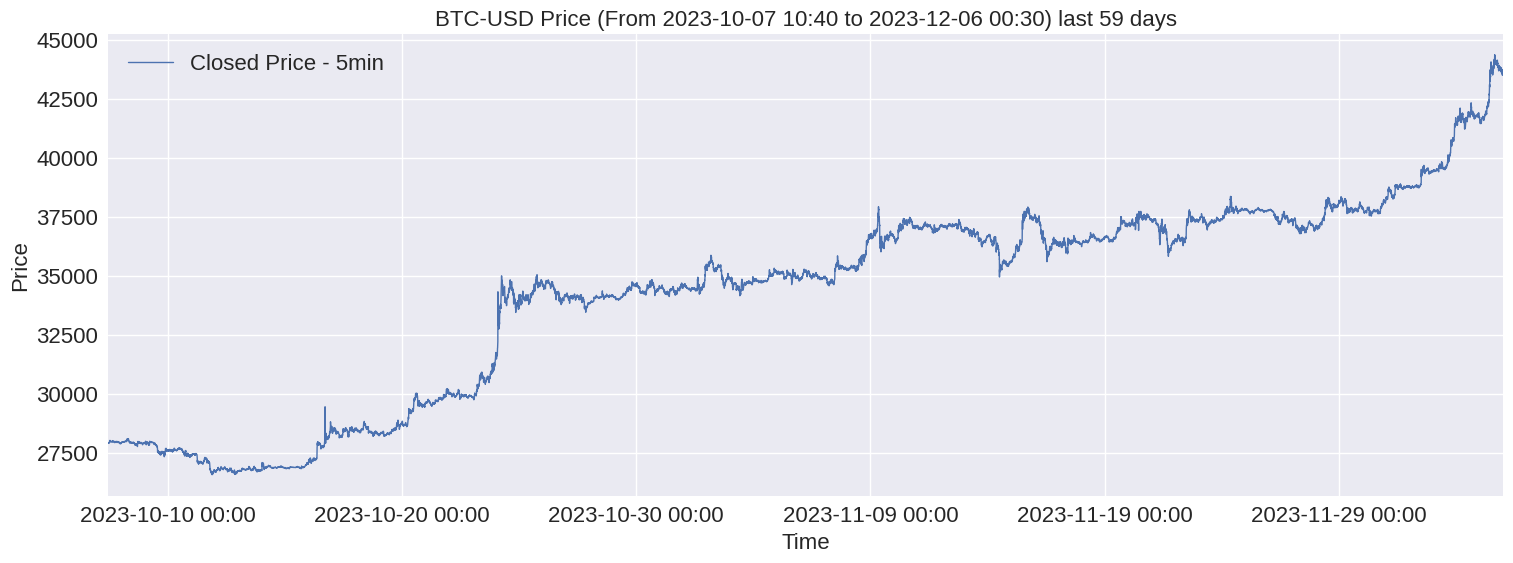

In [9]:
"""
Description:
- Plots the historical closed price of a cryptocurrency.
- The x-axis is formatted with a custom date formatter.

Parameters:
- data (pd.DataFrame): Historical price data with timestamps and closed prices.
- dateformat (str): Custom date format for timestamp display.
"""
dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index]

plt.gca().xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
plt.plot(dates, list(data['Close']), label = 'Closed Price - 5min', linewidth = 1)
plt.xlim([dates[0], dates[-1]])
plt.title('BTC-USD Price (From {} to {}) last {} days'
.format(data.index[0], data.index[-1], (datetime.strptime(data.index[-1], dateformat) - datetime.strptime(data.index[0], dateformat)).days))
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Methods for normalize and denormalize data

In [10]:
def normalize(x_, minmax):
    """
    Description:
    - Normalizes input data within the specified min-max range.

    Parameters:
    - x_ (np.ndarray): Input data to be normalized.
    - minmax (np.ndarray): Array containing the minimum and maximum values.

    Returns:
    - np.ndarray: Normalized data.
    """
    return (x_ - minmax[0]) / (minmax[1] - minmax[0])

def denormalize(x_, minmax):
    """
    Description:
    - Denormalizes input data based on the specified min-max range.

    Parameters:
    - x_ (np.ndarray): Input data to be denormalized.
    - minmax (np.ndarray): Array containing the minimum and maximum values used.

    Returns:
    - np.ndarray: Denormalized data.
    """
    return minmax[0] + ((minmax[1] - minmax[0]) * x_)

# Build Bidirectional Probabilistic GRU

In [11]:
def bi_gru_prob(shape = None, name = None):
    """
    Description:
    - Construct a Bidirectional Probabilistic Gated Recurrent Unit (GRU) model with regularization, batch normalization,
    and distribution output. The distribution is defined as a Normal distribution with the predicted values (loc)
    and a scale parameter derived from a softplus function applied to the predicted values. This approach is employed
    for probabilistic predictions in the context of the model.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Bidirectional Probabilistic GRU model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = Bidirectional(GRU(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg))(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)

    # Output a probabilistic distribution using DistributionLambda
    O = DistributionLambda(lambda t: Normal(loc = t, scale = 1e-2 * tf.math.softplus(1e-2 * t), validate_args = True, allow_nan_stats = False))(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'bi_gru_prob_{name}')
    m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = lambda y, p: -p.log_prob(y), metrics = None)
    return m

# Bidirectional Simple GRU Model with Regularization and Batch Normalization

In [12]:
def bi_gru_simple(shape = None, name = None):
    """
    Description:
    - Construct a Bidirectional Simple Gated Recurrent Unit (GRU) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Bidirectional Simple GRU model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = Bidirectional(GRU(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg))(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    h = Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'bi_gru_simple_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Bidirectional Time Distributed GRU Model with Regularization and Batch Normalization

In [13]:
def bi_gru_time_dist(shape = None, name = None):
    """
    Description:
    - Construct a Bidirectional Time Distributed Gated Recurrent Unit (GRU) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Bidirectional Time Distributed GRU model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = Bidirectional(GRU(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg, return_sequences = True))(I)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = Flatten()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'bi_gru_time_dist_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Probabilistic GRU Model with Regularization and Batch Normalization

In [14]:
def gru_prob(shape = None, name = None):
    """
    Description:
    - Construct a Probabilistic Gated Recurrent Unit (GRU) model with regularization, batch normalization,
    and distribution output. The distribution is defined as a Normal distribution with the predicted values (loc)
    and a scale parameter derived from a softplus function applied to the predicted values. This approach is employed
    for probabilistic predictions in the context of the model.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Probabilistic GRU model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = GRU(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)

    # Output a probabilistic distribution using DistributionLambda
    O = DistributionLambda(lambda t: Normal(loc = t, scale = 1e-2 * tf.math.softplus(1e-2 * t), validate_args = True, allow_nan_stats = False))(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'gru_prob_{name}')
    m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = lambda y, p: -p.log_prob(y), metrics = None)
    return m

# Simple GRU Model with Regularization and Batch Normalization

In [15]:
def gru_simple(shape = None, name = None):
    """
    Description:
    - Construct a Simple Gated Recurrent Unit (GRU) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Simple GRU model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = GRU(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    h = Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'gru_simple_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Time Distributed GRU Model with Regularization and Batch Normalization

In [16]:
def gru_time_dist(shape = None, name = None):
    """
    Description:
    - Construct a Time Distributed Gated Recurrent Unit (GRU) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Time Distributed GRU model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = GRU(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg, return_sequences = True)(I)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = Flatten()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'gru_time_dist_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Bidirectional Probabilistic LSTM Model with Regularization and Batch Normalization

In [17]:
def bi_lstm_prob(shape = None, name = None):
    """
    Description:
    - Construct a Bidirectional Probabilistic Long Short-Term Memory (LSTM) model with regularization, batch normalization,
    and distribution output. The distribution is defined as a Normal distribution with the predicted values (loc)
    and a scale parameter derived from a softplus function applied to the predicted values. This approach is employed
    for probabilistic predictions in the context of the model.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Bidirectional Probabilistic LSTM model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = Bidirectional(LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg))(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)

    # Output a probabilistic distribution using DistributionLambda
    O = DistributionLambda(lambda t: Normal(loc = t, scale = 1e-2 * tf.math.softplus(1e-2 * t), validate_args = True, allow_nan_stats = False))(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'bi_lstm_prob_{name}')
    m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = lambda y, p: -p.log_prob(y), metrics = None)
    return m

# Bidirectional Simple LSTM Model with Regularization and Batch Normalization

In [18]:
def bi_lstm_simple(shape = None, name = None):
    """
    Description:
    - Construct a Bidirectional Simple Long Short-Term Memory (LSTM) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Bidirectional Simple LSTM model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = Bidirectional(LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg))(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    h = Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'bi_lstm_simple_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Bidirectional Time Distributed LSTM Model with Regularization and Batch Normalization

In [19]:
def bi_lstm_time_dist(shape = None, name = None):
    """
    Description:
    - Construct a Bidirectional Time Distributed Long Short-Term Memory (LSTM) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Bidirectional Time Distributed LSTM model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = Bidirectional(LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg, return_sequences = True))(I)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = Flatten()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'bi_lstm_time_dist_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Probabilistic LSTM Model with Regularization and Batch Normalization

In [20]:
def lstm_prob(shape = None, name = None):
    """
    Description:
    - Construct a Probabilistic Long Short-Term Memory (LSTM) model with regularization, batch normalization, and distribution output.
    The distribution is defined as a Normal distribution with the predicted values (loc) and a scale parameter derived from a softplus
    function applied to the predicted values. This approach is employed for probabilistic predictions in the context of the model.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Probabilistic LSTM model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)

    # Output a probabilistic distribution using DistributionLambda
    O = DistributionLambda(lambda t: Normal(loc = t, scale = 1e-2 * tf.math.softplus(1e-2 * t), validate_args = True, allow_nan_stats = False))(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'lstm_prob_{name}')
    m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = lambda y, p: -p.log_prob(y), metrics = None)
    return m

# Simple LSTM Model with Regularization and Batch Normalization

In [21]:
def lstm_simple(shape = None, name = None):
    """
    Description:
    - Construct a simple Long Short-Term Memory (LSTM) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Simple LSTM model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    h = Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'lstm_simple_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

# Time Distributed LSTM Model with Regularization and Batch Normalization

In [22]:
def lstm_time_dist(shape = None, name = None):
    """
    Description:
    - Construct a Time Distributed Long Short-Term Memory (LSTM) model with regularization and batch normalization.

    Parameters:
    - shape (tuple): Input shape for the model.
    - name (str): Name to identify the model.

    Returns:
    - tf.keras.Model: Compiled Time Distributed LSTM model.
    """
    # Set up L1 regularization
    rg = tf.keras.regularizers.l1(l1 = 1e-3)

    # Define model architecture
    I = Input(shape = shape, name = 'close_price')
    h = LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg, return_sequences = True)(I)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 64, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = Flatten()(h)
    O = Activation('sigmoid')(h)

    # Compile the model
    m = Model(inputs = I, outputs = O, name = f'lstm_time_dist_{name}')
    m.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3), loss = 'mae', metrics = None)
    return m

## Method for retrieving the index of a specific layer.

In [23]:
def get_layer_index(model_layers, layer_name):
    for idx, layer in enumerate(model_layers):
        if layer.name == layer_name:
            return idx

# Define a custom callback to monitor and track the R2-Score on the validation dataset.

In [24]:
class TrainingCallback(Callback):
    """
    Description:
    - [TrainingCallback] Custom Callback for Monitoring and Managing Training Process
    This callback monitors the training process, tracks the R2 score, and saves the best model based on R2 improvement on validation dataset.

    Parameters:
    - check_best (bool): Whether to check and save the best model based on the highest R2 score.
    - change_lr (bool): Whether to change the learning rate during training.
    - change_lr_freq (int): Frequency of learning rate changes.
    - model_dir (str): Directory to save the best model and training history.
    - model_name (str): Name of the best model file.
    - valid_data (tuple): Validation data in the form of (valid_X, valid_y).
    - model (tf.keras.Model): The main model being trained.

    Methods:
    - on_train_begin: Called at the start of training.
    - on_train_end: Called at the end of training.
    - on_epoch_begin: Called at the beginning of each epoch.
    - on_epoch_end: Called at the end of each epoch.

    The callback saves the best model based on R2 score and logs the training progress in a text file.
    """
    def __init__(self,
                 check_best = True,
                 change_lr = False,
                 change_lr_freq = None,
                 model_dir = None,
                 model_name = 'best_r2_model',
                 valid_data = None,
                 model = None):
        super(TrainingCallback).__init__()
        if valid_data is None: raise ValueError('You have to define validation data: e.g. valid_data = (valid_X, valid_y)!')
        if model is None: raise ValueError('You have to define model: e.g. model = your_model_name!')
        self.check_best = check_best
        self.change_lr = change_lr
        self.change_lr_freq = change_lr_freq
        self.price_r2, self.valid_X, self.valid_y = 0.0, valid_data[0], valid_data[1]
        if model_dir is None:
            self.best_model_dir = os.path.join(os.getcwd(), 'best_model').replace('\\', '/')
        else:
            self.best_model_dir = model_dir
        if not os.path.isdir(self.best_model_dir): os.makedirs(self.best_model_dir)
        self.best_model_name = model_name
        self.save_best = False
        self.model = model
        self.model_ = None
        self.time = 0
        self.text_file = None

    def on_train_begin(self, logs = None, **kwargs):
        self.text_file = open(f'{self.best_model_dir}_history.txt', 'w')
        if self.check_best:
            self.model.save(f'{self.best_model_dir}/{self.best_model_name}.keras')
            self.model_ = load_model(f'{self.best_model_dir}/{self.best_model_name}.keras', safe_mode = False)
        c = {True: 'On', False: 'Off'}
        text = f'Training started. Checking the best model based on the highest R2-score is {c[self.check_best]}'
        self.text_file.writelines(text + '\n')
        print(text)

    def on_train_end(self, logs = None, **kwargs):
        self.text_file.close()

    def on_epoch_begin(self, epoch, logs = None, **kwargs):
        self.time = time.time()

    def on_epoch_end(self, epoch, logs = None, **kwargs):
        if self.check_best:
            price_check = 'Model Weights Not Changed'
            self.save_best = False
            pred_ = self.model.predict(self.valid_X)
            if np.array(pred_.shape).shape[0] > 1:
                price_r2_ = r2_score(self.valid_y.flatten(), np.mean(pred_, axis = 1))
            else:
                price_r2_ = r2_score(self.valid_y, pred_)
            if price_r2_ > self.price_r2:
                self.model_ = load_model(f'{self.best_model_dir}/{self.best_model_name}.keras', safe_mode = False)
                price_check = 'Model Weights Changed'
                self.price_r2, self.save_best = price_r2_, True
                for layer in self.model.layers:
                    if layer.weights:
                        layer_idx = get_layer_index(self.model_.layers, layer.name)
                        self.model_.layers[layer_idx].set_weights(self.model.layers[layer_idx].get_weights())
            if self.params['epochs'] > 9:
                e = str(int((10 * self.params['epochs']) + epoch + 1))[1:]
            else:
                e = epoch + 1
            t = str(timedelta(seconds = int(time.time() - self.time)))
            if self.save_best:
                self.model_.save(f'{self.best_model_dir}/{self.best_model_name}.keras')
                if 'val_loss' in logs.keys():
                    text = 'Epoch: {}/{} | {} | Price R2 score: {:.4f} | loss: {:.4f}, val_loss: {:.4f} | {} And Best Model Saved'.format(e,
                                                                                                                                          self.params['epochs'],
                                                                                                                                          t,
                                                                                                                                          price_r2_,
                                                                                                                                          logs['loss'],
                                                                                                                                          logs['val_loss'],
                                                                                                                                          price_check)
                else:
                    text = 'Epoch: {}/{} | {} | Price R2 score: {:.4f} | loss: {:.4f} | {} And Best Model Saved'.format(e,
                                                                                                                        self.params['epochs'],
                                                                                                                        t, price_r2_,
                                                                                                                        logs['loss'],
                                                                                                                        price_check)
            else:
                if 'val_loss' in logs.keys():
                    text = 'Epoch: {}/{} | {} | Price R2 score: {:.4f} | loss: {:.4f}, val_loss: {:.4f} | {}'.format(e,
                                                                                                                     self.params['epochs'],
                                                                                                                     t,
                                                                                                                     price_r2_,
                                                                                                                     logs['loss'],
                                                                                                                     logs['val_loss'],
                                                                                                                     price_check)
                else:
                    text = 'Epoch: {}/{} | {} | Price R2 score: {:.4f} | loss: {:.4f} | {}'.format(e,
                                                                                                   self.params['epochs'],
                                                                                                   t,
                                                                                                   price_r2_,
                                                                                                   logs['loss'],
                                                                                                   price_check)
            self.text_file.writelines(text + '\n')
            print(text)

# Transfer Model for Probabilistic Prediction with Fine-Tuning (trained model on BTC price data)

In [25]:
def transfer_model(transfer_model_path = None, transfer_model_name = None, name = 'best_TRXPred_gru_prob'):
    """
    Description:
    - Load a pre-trained model, freeze layers, and create a new model for transfer learning with fine-tuning.

    Parameters:
    - transfer_model_path (str): Path to the directory containing the pre-trained model.
    - transfer_model_name (str): Name of the pre-trained model file.
    - name (str): Name for the new transfer model.

    Returns:
    - tf.keras.Model: Compiled transfer model with fine-tuning for probabilistic prediction.
    """
    # Default values for transfer model path and name
    if transfer_model_path is None:
        transfer_model_path = 'best_BTCPred_gru_prob'
    if transfer_model_name is None:
        transfer_model_name = 'best_BTCPred_gru_prob'

    # Load the pre-trained model
    m = load_model(f'{transfer_model_path}/{transfer_model_name}.keras', safe_mode = False)

    # Freeze layers except the last one
    for layer in m.layers[:-3]:
        layer.trainable = False

    # Set a new name for the transfer model
    m._name = name

    # Compile the transfer model with a specified optimizer and loss function (NLL)
    m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss = lambda y, p: -p.log_prob(y), metrics = None)
    return m

# Data Splitting for Time Series Prediction

In [26]:
def split_data(close_price = None, training_len = None, testing_len = None, analyzing_duration = None):
    """
    Description:
    - Split time series data into training and testing sets for sequence prediction.

    Parameters:
    - close_price (numpy.ndarray): Time series data of closing prices.
    - training_len (int): Length of the training set.
    - testing_len (int): Length of the testing set.
    - analyzing_duration (int): Duration of the sequence used for prediction.

    Returns:
    - tuple: Tuple containing training and testing sets (train_X, train_y, test_X, test_y).
      - train_X (numpy.ndarray): Training input sequences.
      - train_y (numpy.ndarray): Training output values.
      - test_X (numpy.ndarray): Testing input sequences.
      - test_y (numpy.ndarray): Testing output values.
    """
    # Initialize lists to store training and testing data
    train_X, train_y = [], []
    test_X, test_y = [], []

    # Generate training sequences and corresponding output values
    for idx in range(training_len - analyzing_duration):
        train_X.append(close_price[idx:analyzing_duration + idx].reshape(analyzing_duration))
        train_y.append(close_price[idx + analyzing_duration])

    # Reshape training data into the required format
    train_X, train_y = np.asarray(train_X).reshape((len(train_X), analyzing_duration, 1)), np.asarray(train_y)

    # Generate testing sequences and corresponding output values
    for idx in range(training_len - analyzing_duration, training_len + testing_len - analyzing_duration):
        test_X.append(close_price[idx:analyzing_duration + idx].reshape(analyzing_duration))
        test_y.append(close_price[idx + analyzing_duration])

    # Reshape testing data into the required format
    test_X, test_y = np.asarray(test_X).reshape((len(test_X), analyzing_duration, 1)), np.asarray(test_y)
    return train_X, train_y, test_X, test_y

# Plotting Time Series Prediction Results

In [27]:
def plot_prediction(y_train, y_test, y_pred, model_name = None, whole_data = True):
    """
    Description:
    - Generate a plot to visualize the results of time series prediction.

    Parameters:
    - y_train (numpy.ndarray): True values of the training set.
    - y_test (numpy.ndarray): True values of the testing set.
    - y_pred (numpy.ndarray): Predicted values, including mean and optional confidence interval.
    - model_name (str): Name of the model for plot title.
    - whole_data (bool): Whether to include the entire dataset in the plot.

    Returns:
    - None: Displays the generated plot.
    """
    # Set up plot parameters
    plt.rcParams.update({'figure.figsize': [18, 6]})

    if whole_data:
        a, b, c = [], [], []
        a.extend(denormalize(y_train, close_minmax))
        a.extend([np.nan] * len(y_test))
        b.extend([np.nan] * len(y_train))
        b.extend(denormalize(y_test, close_minmax))
        c.extend([np.nan] * len(y_train))
        c.extend(denormalize(y_pred.mean(axis = 1), close_minmax))
        dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index[:-analysis_duration]]

        fig, ax = plt.subplots(1)

        ax.xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
        ax.plot(dates, a, label = 'Train', linewidth = 1)
        ax.plot(dates, b, label = 'Test', linewidth = 1)
        ax.plot(dates, c, label = 'Prediction', alpha = .8, linewidth = 1, linestyle = '-.')
    else:
        dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index[-len(y_test):]]

        fig, ax = plt.subplots(1)

        ax.xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
        ax.plot(dates, denormalize(y_test, close_minmax), label = 'Test', color = 'k', linewidth = 1)
        ax.plot(dates, denormalize(y_pred.mean(axis = 1), close_minmax), label = 'Prediction', color = 'r', linewidth = 1)
        if y_pred.shape[1] > 1:
            ax.fill_between(dates, denormalize(y_pred.mean(axis = 1) + .5 * y_pred.std(axis = 1), close_minmax),
                            denormalize(y_pred.mean(axis = 1) - .5 * y_pred.std(axis = 1), close_minmax),
                            alpha = .25, label = 'Prediction Bounds', color = 'c')
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_title(f'Best Model: {model_name}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.tick_params(axis = 'x', rotation = 15)
    ax.legend()
    plt.show()

# Base Models Dictionary

In [28]:
"""
Description:
- Dictionary containing base model names as keys and corresponding model functions as values.
These models are used as building blocks for constructing more complex models and architectures in the workflow.
"""
base_models_list = {
    'bi_gru_prob':          bi_gru_prob,
    'bi_gru_simple':        bi_gru_simple,
    'bi_gru_time_dist':     bi_gru_time_dist,
    'gru_prob':             gru_prob,
    'gru_simple':           gru_simple,
    'gru_time_dist':        gru_time_dist,
    'bi_lstm_prob':         bi_lstm_prob,
    'bi_lstm_simple':       bi_lstm_simple,
    'bi_lstm_time_dist':    bi_lstm_time_dist,
    'lstm_prob':            lstm_prob,
    'lstm_simple':          lstm_simple,
    'lstm_time_dist':       lstm_time_dist
}

# Model Training Configuration

In [29]:
"""
Description:
- Configuration settings for training the time series prediction models.

Parameters:
- test_split_percentage (float): Percentage of data reserved for testing.
- validation_split_percentage (float): Percentage of training data used for validation.
- epochs (int): Number of training epochs.
- batch_size (int): Batch size for training.
- verbose (int): Verbosity level during training (0 for silent).
- analysis_duration (int): Duration of the sequence used for prediction.
- price_pairs (str): Symbol pairs for the cryptocurrency prices dataset.
"""
test_split_percentage = .8
validation_split_percentage = .2
epochs = 20
batch_size = 32
verbose = 0
analysis_duration = 6
price_pairs = 'BTCUSD'

# Price Preprocessing and Normalization Parameters

In [30]:
"""
Parameters for normalizing cryptocurrency closing prices:
- alpha (float): Scaling factor for the minimum value.
- beta (float): Scaling factor for the maximum value.
- close_price (numpy.ndarray): NumPy array containing closing prices.
- data_len (int): Total length of the price data.
- train_len (int): Length of the training data.
- test_len (int): Length of the testing data.
- close_minmax (numpy.ndarray): Min-max normalization range for closing prices.
"""
alpha, beta = .8, 1.2
close_price = pd.Series.to_numpy(data['Close'])
data_len = close_price.shape[0]
train_len = int((test_split_percentage * data_len) // analysis_duration * analysis_duration)
test_len = int(data_len - train_len)
close_minmax = np.array([alpha * close_price.min(), beta * close_price.max()], dtype = 'float32')

# Price Normalization and Save

In [31]:
"""
Description:
- Normalize the closing prices of cryptocurrency data and save the min-max normalization range.

Parameters:
- close_price (numpy.ndarray): Reshaped and normalized closing prices.
- data_len (int): Total length of the price data.
- close_minmax (numpy.ndarray): Min-max normalization range for closing prices.
- price_pairs (str): Symbol pairs for the cryptocurrency prices dataset.
"""
close_price = close_price.reshape((data_len, 1)).astype('float32')
close_price = normalize(close_price, close_minmax)
np.save(f'close_minmax_{price_pairs.lower()}.npy', close_minmax)

# Data Splitting for Training and Validation

In [32]:
"""
Description:
- Split the time series data into training, testing, and validation sets for model training.

Parameters:
- X_train, y_train, X_test, y_test (numpy.ndarray): Training and testing data split.
- X_val, y_val (numpy.ndarray): Validation data split from the training set.
- close_price (numpy.ndarray): Reshaped and normalized closing prices.
- train_len (int): Length of the training data.
- test_len (int): Length of the testing data.
- validation_split_percentage (float): Percentage of training data used for validation.
- analyzing_duration (int): Duration of the sequence used for prediction.
"""
X_train, y_train, X_test, y_test = split_data(close_price = close_price,
                                              training_len = train_len,
                                              testing_len = test_len,
                                              analyzing_duration = analysis_duration)
X_val, y_val = X_train[int(train_len - (validation_split_percentage * train_len)):], y_train[int(train_len - (validation_split_percentage * train_len)):]
X_train, y_train = X_train[:int(train_len - (validation_split_percentage * train_len))], y_train[:int(train_len - (validation_split_percentage * train_len))]

# Train multiple base models, evaluate their performance on the test set, and store the results.

In [33]:
"""
Parameters:
- base_models_list (dict): Dictionary containing base model functions.
- X_train, y_train (numpy.ndarray): Training data and labels.
- X_test, y_test (numpy.ndarray): Testing data and labels.
- X_val, y_val (numpy.ndarray): Validation data and labels.
- close_minmax (numpy.ndarray): Min-max values for denormalization.
- epochs (int): Number of training epochs.
- batch_size (int): Size of each training batch.
- verbose (int): Verbosity mode for training output.
- analysis_duration (int): Duration of the sequence used for prediction.
- price_pairs (str): String identifier for the price pair.

Returns:
- y_pred_best (dict): Predictions from the best models.
- models_test_result (dict): Evaluation metrics for each trained model on the test set.
"""

y_pred_best, models_test_result = {}, {}

for selected_model in list(base_models_list.items()):
    m_name_ = f'best_{price_pairs[:3]}Pred_{selected_model[0]}'
    models_test_result.update({f'{m_name_}': {}})
    if os.path.isfile(f'{m_name_[:-2]}_history.npy'):
        continue
    out_path = m_name_.replace('best_', '')
    if not os.path.isdir(out_path): os.makedirs(out_path)
    out_path_best = m_name_

    K.clear_session()
    model = selected_model[1](**{'shape': X_train.shape[1:], 'name': price_pairs.lower()})
    model.summary(line_length = 140)

    tbcall = TrainingCallback(model_dir = out_path_best,
                              valid_data = (X_val, y_val),
                              model = model, model_name = m_name_)

    model_history = model.fit(X_train, y_train,
                              epochs = epochs, batch_size = batch_size, callbacks = tbcall, verbose = verbose)

    model.save(f'{out_path}/{m_name_.replace("best", "fulltrained")}.keras')
    best_model = load_model(f'{out_path_best}/{m_name_}.keras', safe_mode = False)

    test_p = model.predict(X_test)
    test_p_best = best_model.predict(X_test)
    y_pred_best.update({f'{m_name_}': test_p_best})

    models_test_result[f'{m_name_}'].update({'r2_score': float(r2_score(denormalize(y_test, close_minmax),
                                                                        denormalize(test_p_best.mean(axis = 1), close_minmax)))})
    models_test_result[f'{m_name_}'].update({'mean_absolute_percentage_error': float(mape(denormalize(y_test, close_minmax),
                                                                                          denormalize(test_p_best.mean(axis = 1), close_minmax)))})
    models_test_result[f'{m_name_}'].update({'explained_variance_score': float(evs(denormalize(y_test, close_minmax),
                                                                                   denormalize(test_p_best.mean(axis = 1), close_minmax)))})
    models_test_result[f'{m_name_}'].update({'mean_squared_log_error': float(msle(denormalize(y_test, close_minmax),
                                                                                  denormalize(test_p_best.mean(axis = 1), close_minmax)))})
    models_test_result[f'{m_name_}'].update({'mean_poisson_deviance': float(mpd(denormalize(y_test, close_minmax),
                                                                                denormalize(test_p_best.mean(axis = 1), close_minmax)))})
    models_test_result[f'{m_name_}'].update({'max_error': float(max_error(denormalize(y_test, close_minmax),
                                                                          denormalize(test_p_best.mean(axis = 1), close_minmax)))})

Model: "bi_gru_prob_btcusd"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                                  Output Shape                                            Param #              
 close_price (InputLayer)                                      [(None, 6, 1)]                                          0                    
                                                                                                                                            
 bidirectional (Bidirectional)                                 (None, 512)                                             397824               
                                                                                                                                            
 batch_normalization (BatchNormalization)                      (None, 512)                                             2048   

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:10 | Price R2 score: -62.8217 | loss: 594.7126 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -12.6424 | loss: 29.0815 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 03/20 | 0:00:03 | Price R2 score: 0.2683 | loss: 9.9826 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: -1.0012 | loss: 8.5920 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 05/20 | 0:00:03 | Price R2 score: -15.2364 | loss: 9.0124 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 06/20 | 0:00:03 | Price R2 score: -0.7885 | loss: 6.7250 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 07/20 | 0:00:03 | Price R2 score: -1.5600 | loss: 6.6448 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -13.3119 | loss: 5.7721 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 09/20 | 0:00:03 | Price R2 score: -0.5346 | loss: 5.6502 | Model Weights Not Changed
86/86 [=============

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:08 | Price R2 score: -15.9001 | loss: 1.1499 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -25.7423 | loss: 0.2622 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step


Epoch: 03/20 | 0:00:03 | Price R2 score: 0.9595 | loss: 0.2260 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: -2.8754 | loss: 0.2223 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: 0.6071 | loss: 0.2238 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: 0.5026 | loss: 0.2233 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 07/20 | 0:00:03 | Price R2 score: -0.3941 | loss: 0.2242 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -12.7957 | loss: 0.2230 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -5.8687 | loss: 0.2227 | Model Weights Not Changed
86/86 [================

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 4ms/step
Epoch: 01/20 | 0:00:08 | Price R2 score: -14.6359 | loss: 1.1708 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -35.0980 | loss: 0.2563 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 03/20 | 0:00:02 | Price R2 score: -3.0379 | loss: 0.2264 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: -0.0211 | loss: 0.2251 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 05/20 | 0:00:03 | Price R2 score: -0.0428 | loss: 0.2252 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 06/20 | 0:00:04 | Price R2 score: 0.9440 | loss: 0.2252 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 07/20 | 0:00:03 | Price R2 score: 0.1106 | loss: 0.2246 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -0.0468 | loss: 0.2256 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 09/20 | 0:00:03 | Price R2 score: 0.7542 | loss: 0.2248 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 10/20 | 0:00:02 | Price R2 score: -1.8284 | loss: 0.2244 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 11/20 | 0:00:02 | Price R2 score: -0.4416 | loss: 0.2240 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 12/20 | 0:00:03 | Price R2 score: 0.9704 | loss: 0.2246 | Model Weights Changed And Best Model Saved
86/86 [=

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:06 | Price R2 score: -63.2176 | loss: 542.4722 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -18.1095 | loss: 24.0731 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 03/20 | 0:00:02 | Price R2 score: -2.5799 | loss: 3.8114 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: -27.8157 | loss: 5.1861 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: -16.1684 | loss: 4.5522 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: -46.5328 | loss: 4.2011 | Model Weights Not Changed
86/86 [==============================] - 0s 

Epoch: 11/20 | 0:00:02 | Price R2 score: 0.9515 | loss: 2.8002 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 12/20 | 0:00:02 | Price R2 score: 0.9815 | loss: 4.0425 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 13/20 | 0:00:02 | Price R2 score: -0.1146 | loss: 2.6769 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 14/20 | 0:00:02 | Price R2 score: -1.9939 | loss: 2.9055 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 15/20 | 0:00:02 | Price R2 score: 0.9715 | loss: 2.7259 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 16/20 | 0:00:02 | Price R2 score: 0.9700 | loss: 3.2338 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 17/20 | 0:00:02 | Price R2 score: 0.9473 | loss: 2.0840 | Model Weights Not Changed
86/86 [==

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 2ms/step
Epoch: 01/20 | 0:00:05 | Price R2 score: -9.6707 | loss: 0.7397 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -33.1156 | loss: 0.1669 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 03/20 | 0:00:03 | Price R2 score: -2.8275 | loss: 0.1224 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step


Epoch: 04/20 | 0:00:03 | Price R2 score: 0.8815 | loss: 0.1215 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 2ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: -1.8933 | loss: 0.1207 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: 0.9101 | loss: 0.1208 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 07/20 | 0:00:03 | Price R2 score: 0.8730 | loss: 0.1215 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -0.3174 | loss: 0.1207 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -0.3860 | loss: 0.1208 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 10/20 | 0:00:02 | Price R2 score: 0.9161 | loss: 0.1203 | Model Weights Changed And Best Mod

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 2ms/step
Epoch: 01/20 | 0:00:05 | Price R2 score: -12.5362 | loss: 0.7592 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -41.5004 | loss: 0.1581 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 03/20 | 0:00:02 | Price R2 score: -21.7201 | loss: 0.1265 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step


Epoch: 04/20 | 0:00:03 | Price R2 score: 0.5279 | loss: 0.1243 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 2ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: 0.9545 | loss: 0.1238 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 2ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: -4.5521 | loss: 0.1227 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 07/20 | 0:00:02 | Price R2 score: -2.6215 | loss: 0.1231 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: 0.0855 | loss: 0.1222 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -9.4087 | loss: 0.1226 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 10/20 | 0:00:02 | Price R2 score: 0.0492 | loss: 0.1232 | Model Weights Not Changed
86/86 [=

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:08 | Price R2 score: -64.9905 | loss: 545.7847 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -14.5245 | loss: 28.7165 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 03/20 | 0:00:03 | Price R2 score: 0.5690 | loss: 9.2654 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:03 | Price R2 score: -2.1121 | loss: 8.9064 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: -0.3433 | loss: 6.5002 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: -17.4621 | loss: 6.9398 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 07/20 | 0:00:02 | Price R2 score: -3.3314 | loss: 6.6306 | Model Weights Not Changed
86/86 [==============================] - 0s 5ms/step
Epoch: 08/20 | 0:00:03 | Price R2 score: -1.5078 | loss: 5.4758 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -0.3816 | loss: 6.0685 | Model Weights Not Changed
86/86 [==============

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 4ms/step
Epoch: 01/20 | 0:00:08 | Price R2 score: -0.2155 | loss: 1.6069 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -19.7303 | loss: 0.5841 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 03/20 | 0:00:03 | Price R2 score: 0.9716 | loss: 0.3808 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: 0.6630 | loss: 0.2874 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 05/20 | 0:00:03 | Price R2 score: 0.5867 | loss: 0.2876 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: 0.7113 | loss: 0.2859 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 07/20 | 0:00:03 | Price R2 score: 0.8594 | loss: 0.2859 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: 0.5885 | loss: 0.2855 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 09/20 | 0:00:03 | Price R2 score: 0.8810 | loss: 0.2855 | Model Weights Not Changed
86/86 [=====================

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:07 | Price R2 score: -19.3817 | loss: 1.6218 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 02/20 | 0:00:03 | Price R2 score: -41.6584 | loss: 0.5768 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 03/20 | 0:00:03 | Price R2 score: -0.5840 | loss: 0.3788 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: -5.9169 | loss: 0.2880 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 05/20 | 0:00:03 | Price R2 score: 0.4303 | loss: 0.2884 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 4ms/step
Epoch: 06/20 | 0:00:04 | Price R2 score: 0.9140 | loss: 0.2873 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 07/20 | 0:00:02 | Price R2 score: -7.0669 | loss: 0.2882 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -8.6509 | loss: 0.2865 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -0.7191 | loss: 0.2887 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 10/20 | 0:00:04 | Price R2 score: 0.9493 | loss: 0.2880 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 11/20 | 0:00:02 | Price R2 score: -5.7128 | loss: 0.2874 | Model Weights No

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:06 | Price R2 score: -63.3837 | loss: 510.9076 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -15.5063 | loss: 24.9325 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 03/20 | 0:00:02 | Price R2 score: 0.0514 | loss: 5.2461 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: -3.0175 | loss: 4.5791 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: -1.8805 | loss: 4.6339 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: -107.2537 | loss: 3.7859 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 07/20 | 0:00:02 | Price R2 score: -63.4320 | loss: 4.2502 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -4.5377 | loss: 2.8608 | Model Weights Not Changed
86/86 [==============================] - 0s 4ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -1.8134 | loss: 3.5099 | Model Weights Not Changed
86/86 [============

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:06 | Price R2 score: -1.2740 | loss: 1.0729 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -32.2963 | loss: 0.3318 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step


Epoch: 03/20 | 0:00:02 | Price R2 score: 0.4739 | loss: 0.2077 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 2ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: 0.9503 | loss: 0.1541 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 4ms/step
Epoch: 05/20 | 0:00:03 | Price R2 score: 0.4626 | loss: 0.1535 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: 0.2875 | loss: 0.1530 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 07/20 | 0:00:02 | Price R2 score: 0.9205 | loss: 0.1520 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: -0.5145 | loss: 0.1522 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: 0.8991 | loss: 0.1511 | Model Weights Not Changed
86/86 [===

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step
Epoch: 01/20 | 0:00:05 | Price R2 score: -9.9963 | loss: 0.9577 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 02/20 | 0:00:02 | Price R2 score: -44.7008 | loss: 0.3212 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step


Epoch: 03/20 | 0:00:02 | Price R2 score: 0.5678 | loss: 0.2063 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 04/20 | 0:00:02 | Price R2 score: 0.8832 | loss: 0.1573 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 2ms/step
Epoch: 05/20 | 0:00:02 | Price R2 score: -1.2243 | loss: 0.1549 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 06/20 | 0:00:02 | Price R2 score: -5.4495 | loss: 0.1561 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 07/20 | 0:00:02 | Price R2 score: 0.0289 | loss: 0.1552 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 08/20 | 0:00:02 | Price R2 score: 0.5093 | loss: 0.1539 | Model Weights Not Changed
86/86 [==============================] - 0s 2ms/step
Epoch: 09/20 | 0:00:02 | Price R2 score: -3.8009 | loss: 0.1548 | Model Weights Not Changed
86/86 [=

# Prediction visualization

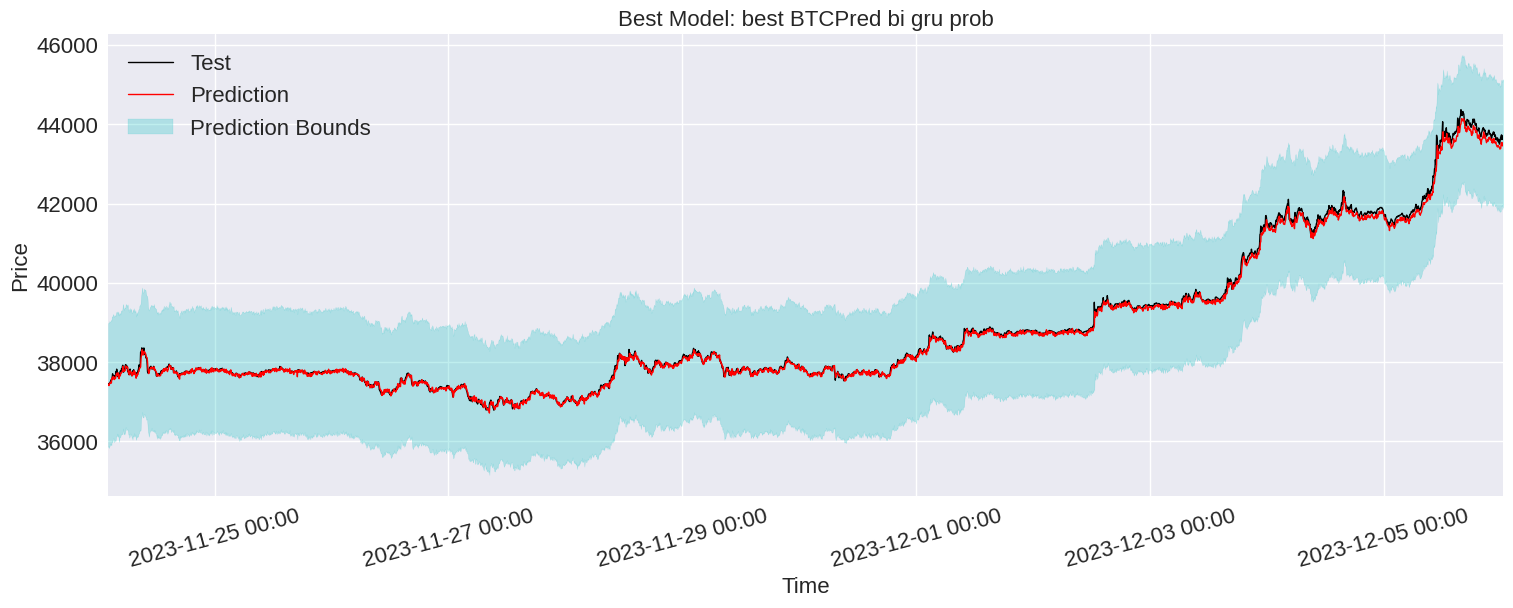

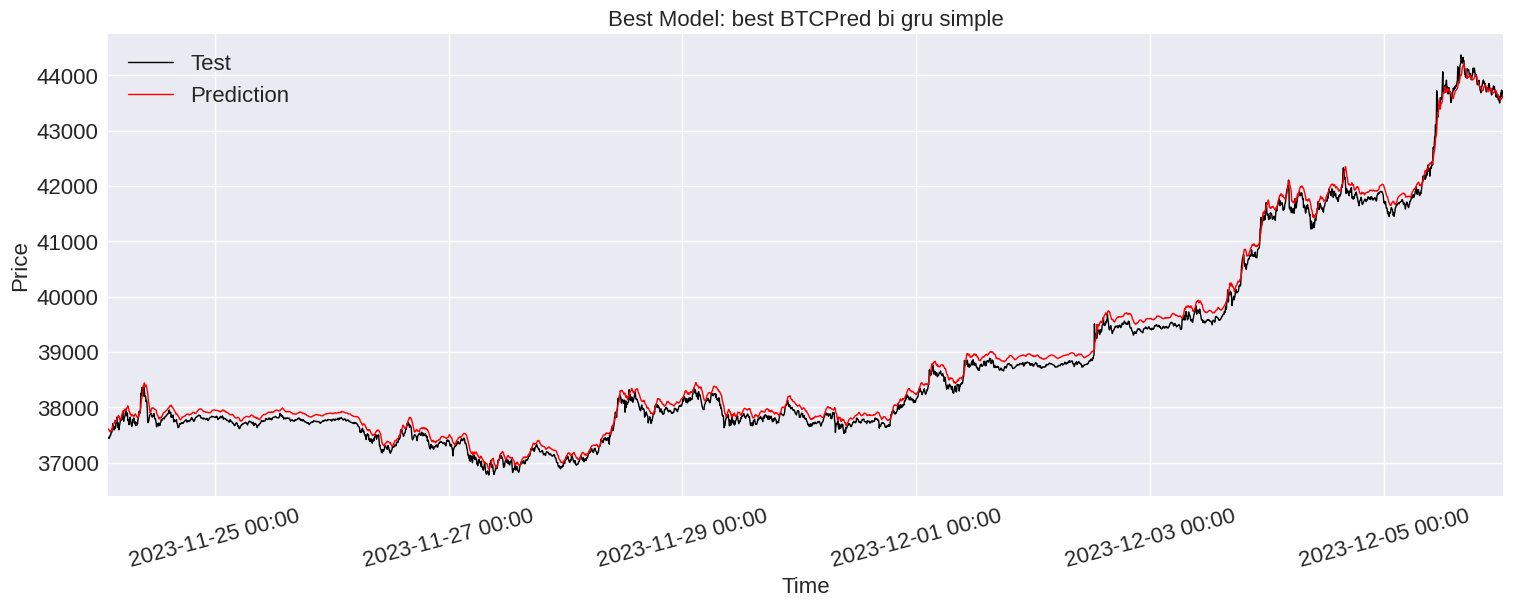

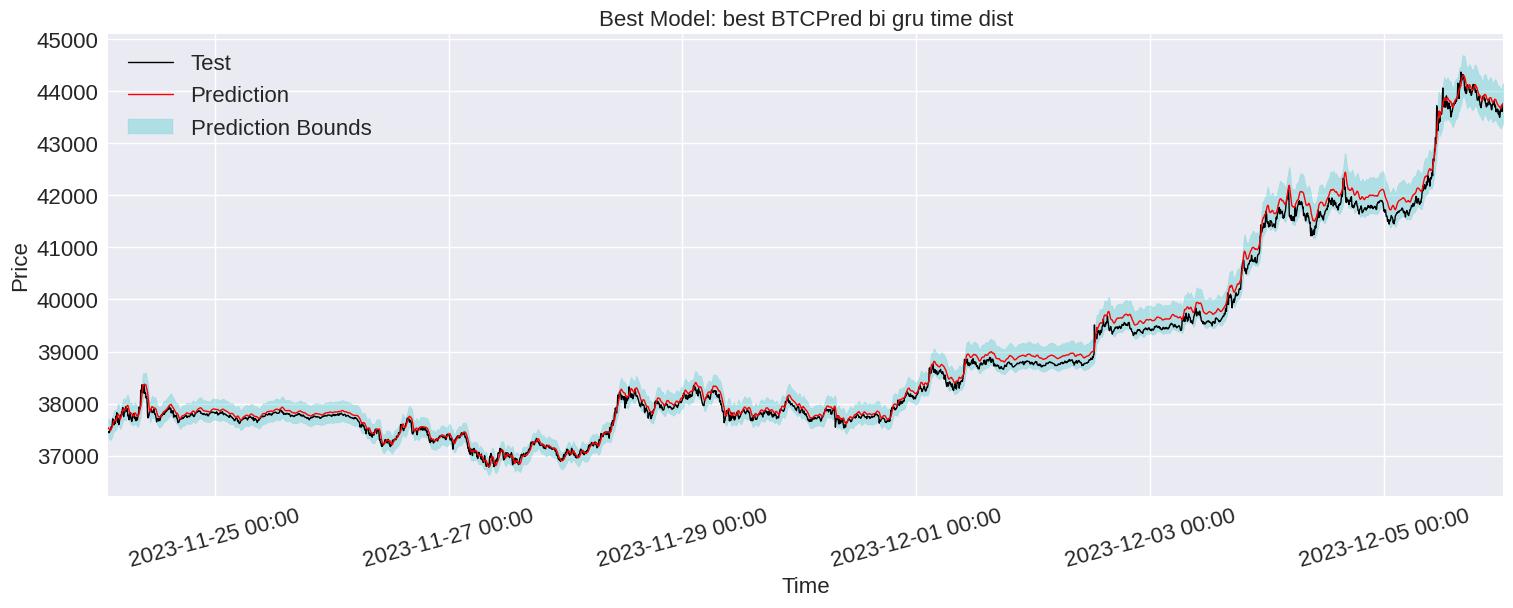

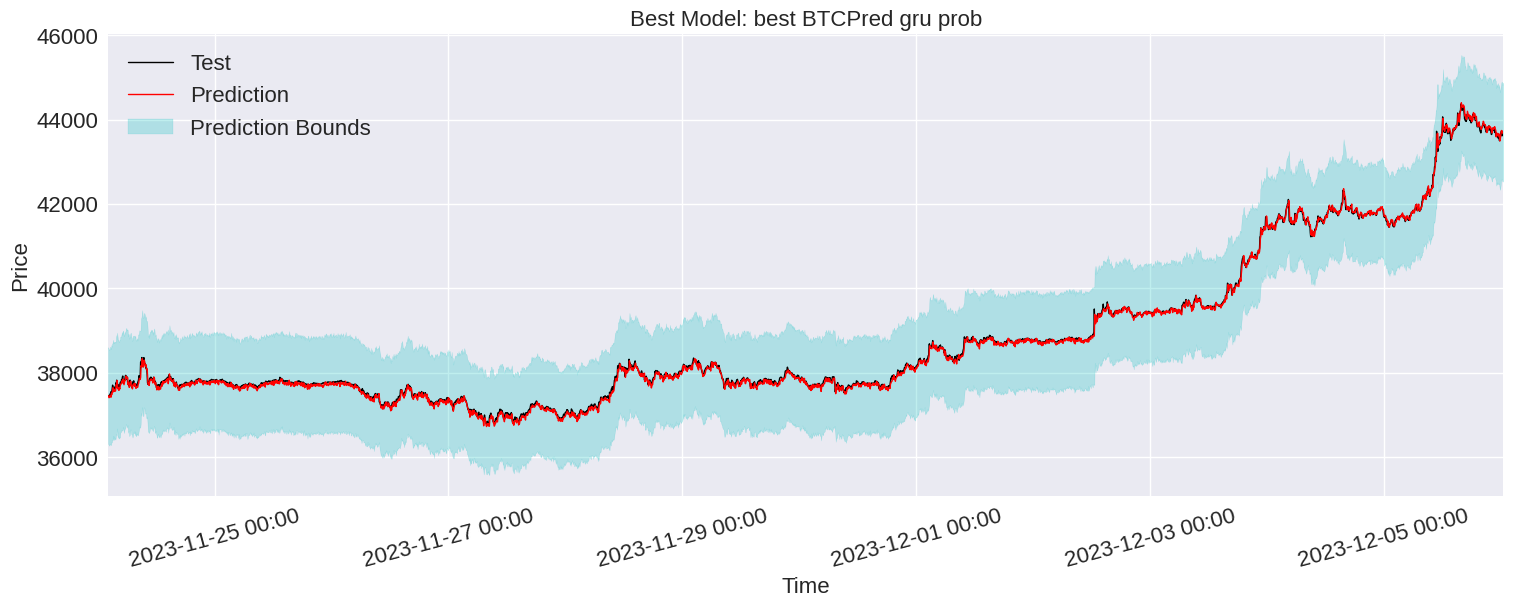

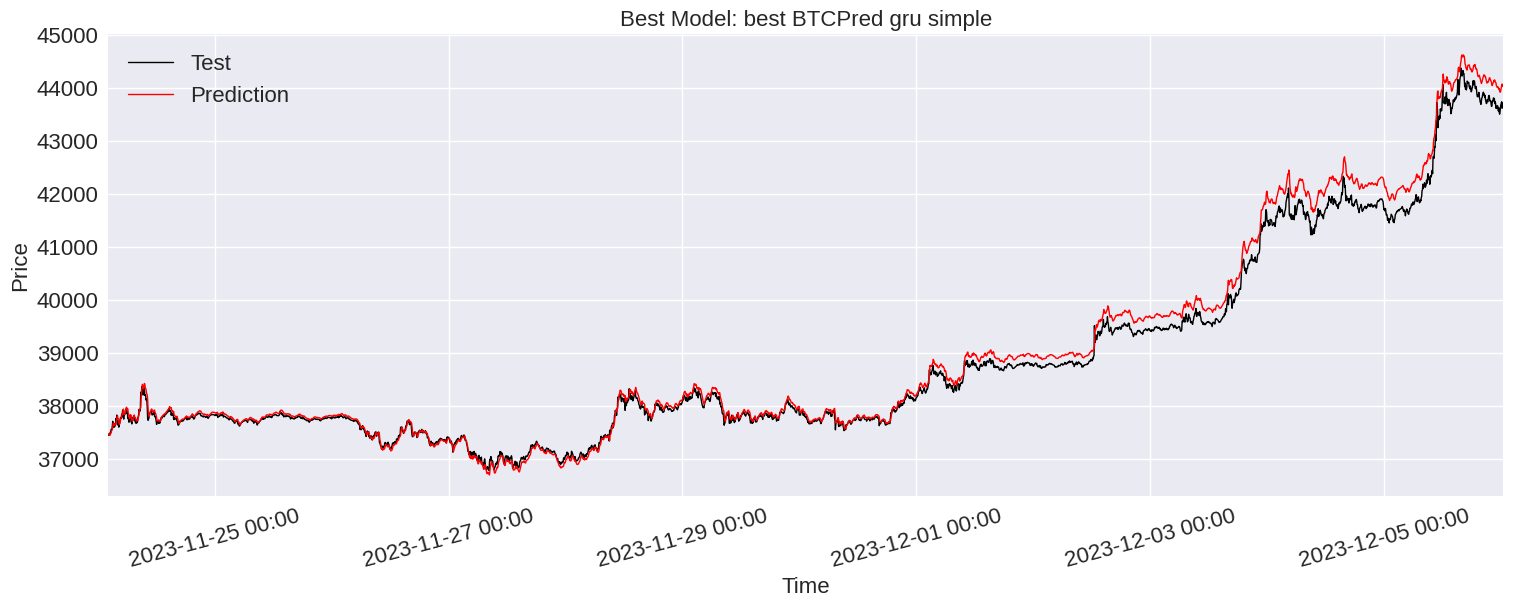

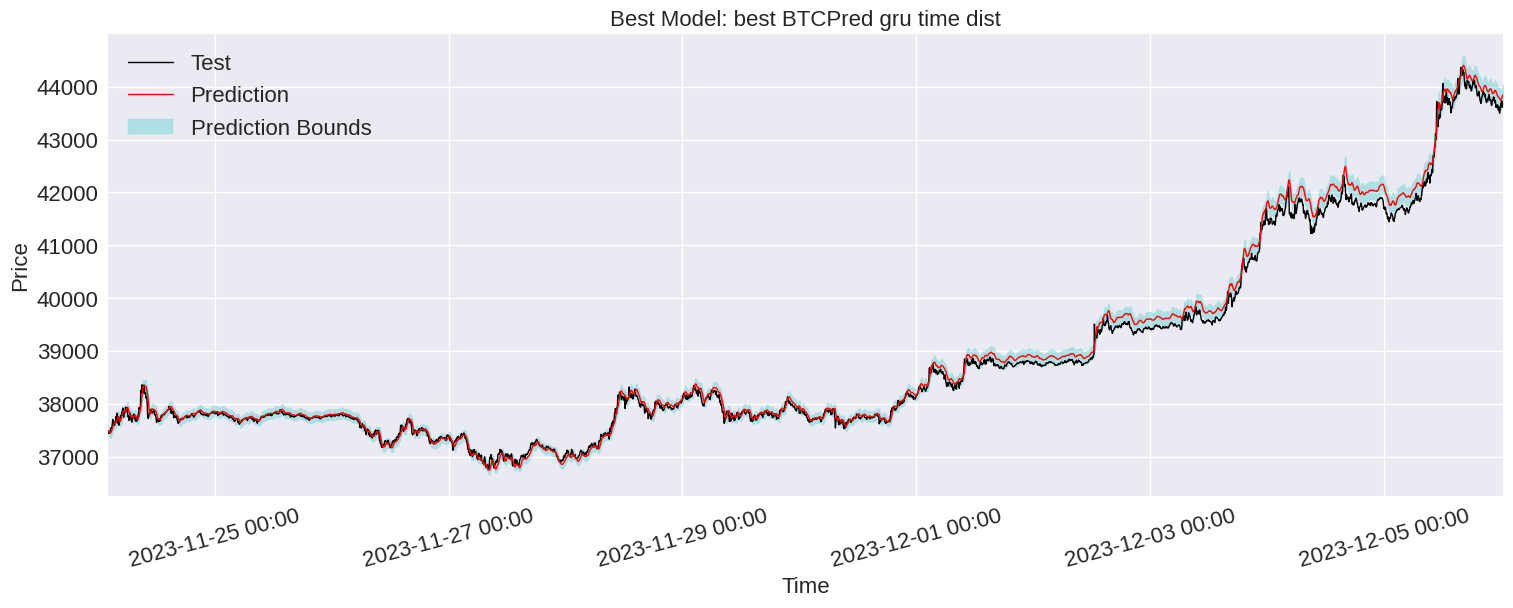

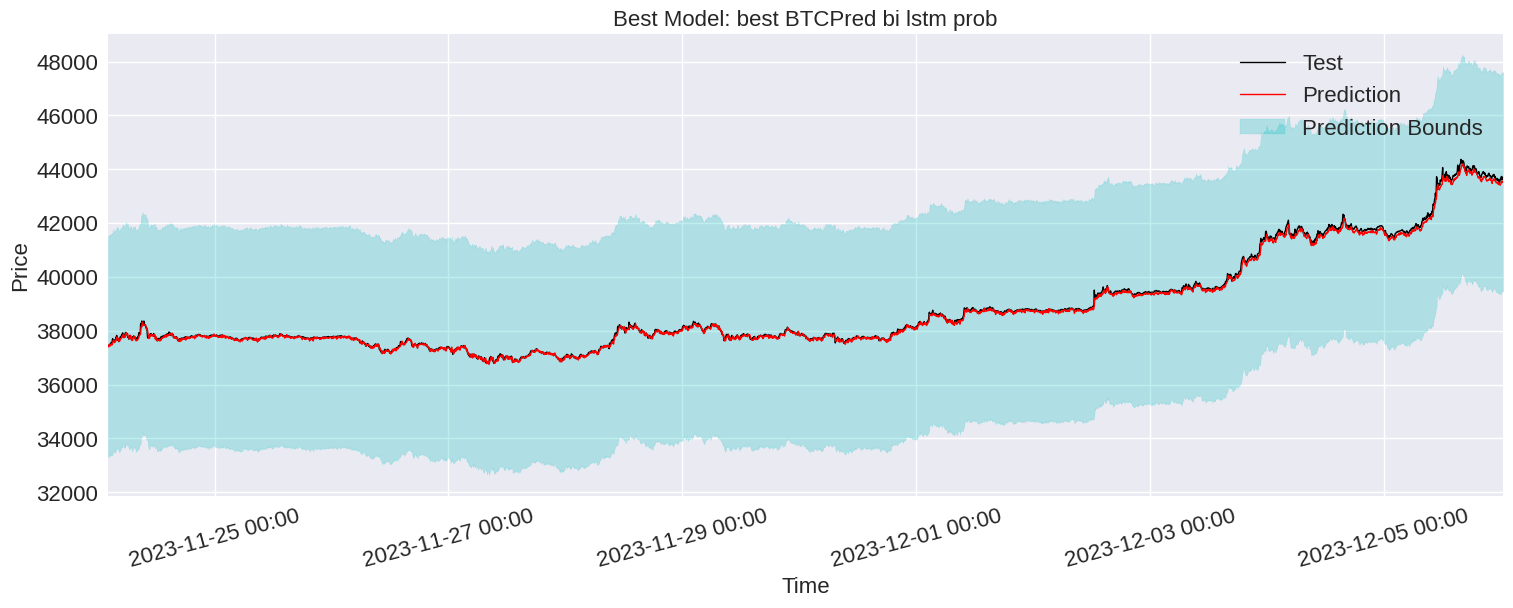

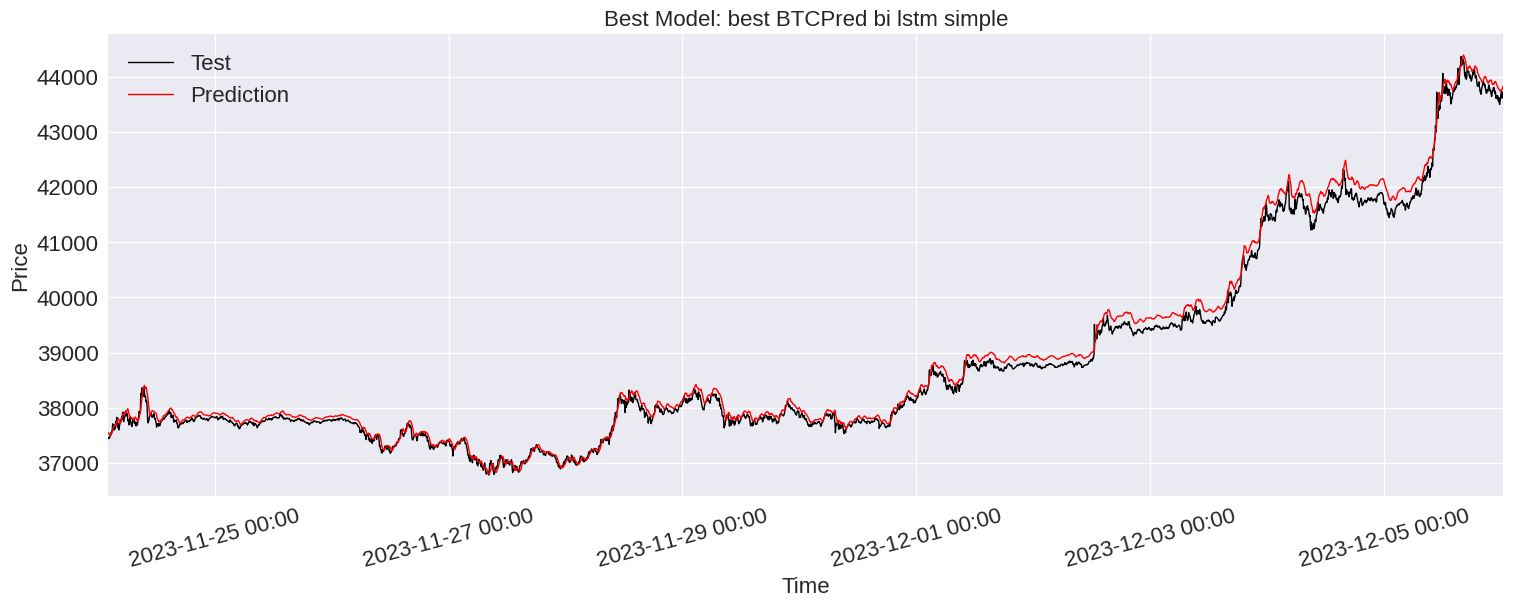

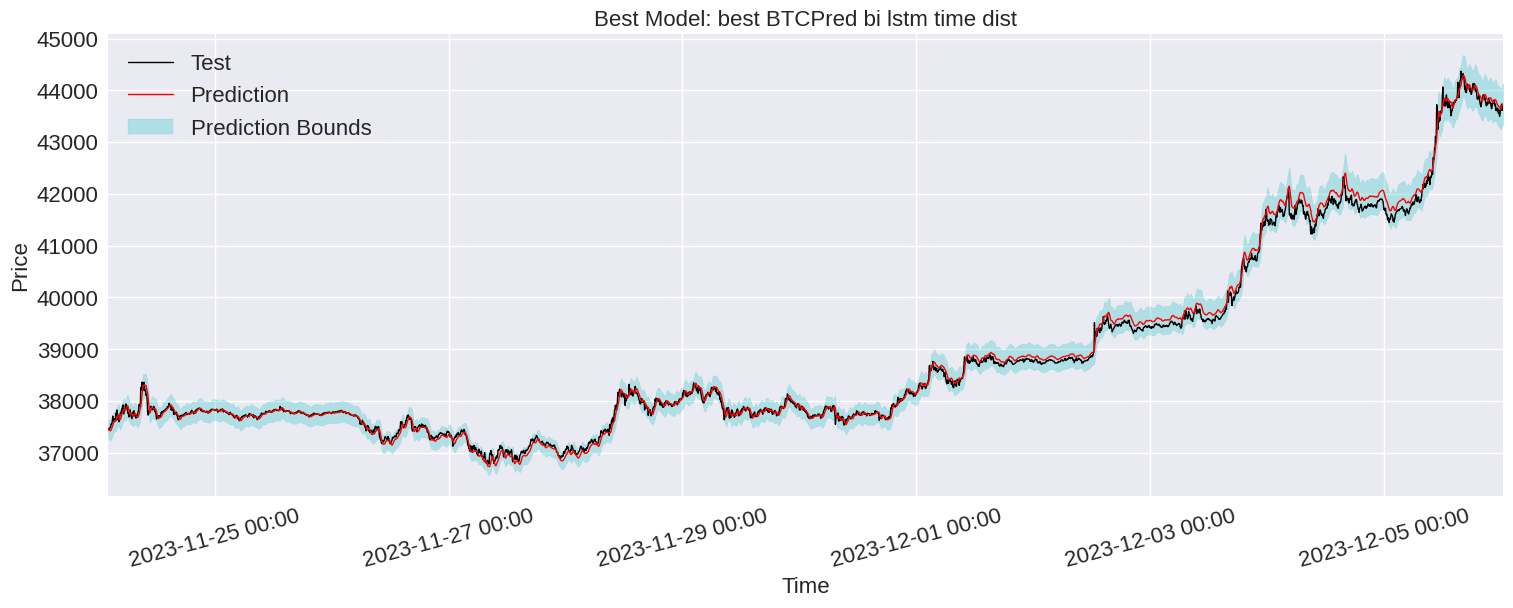

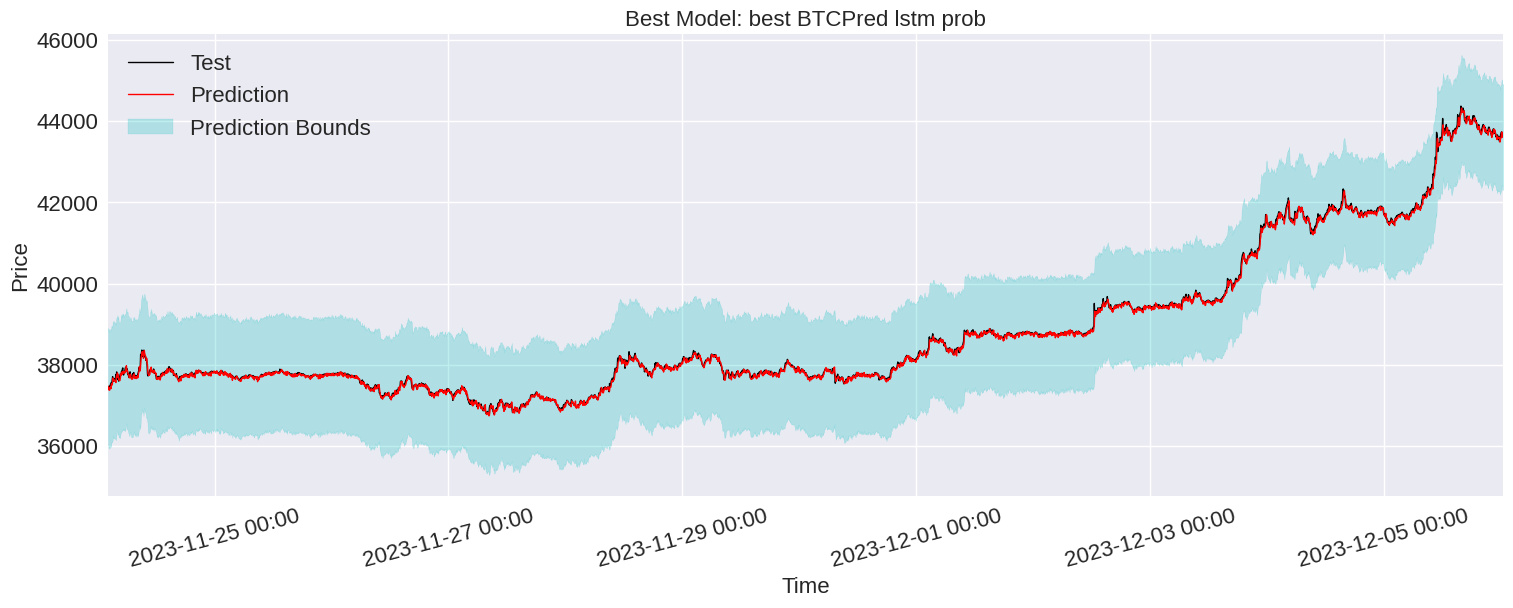

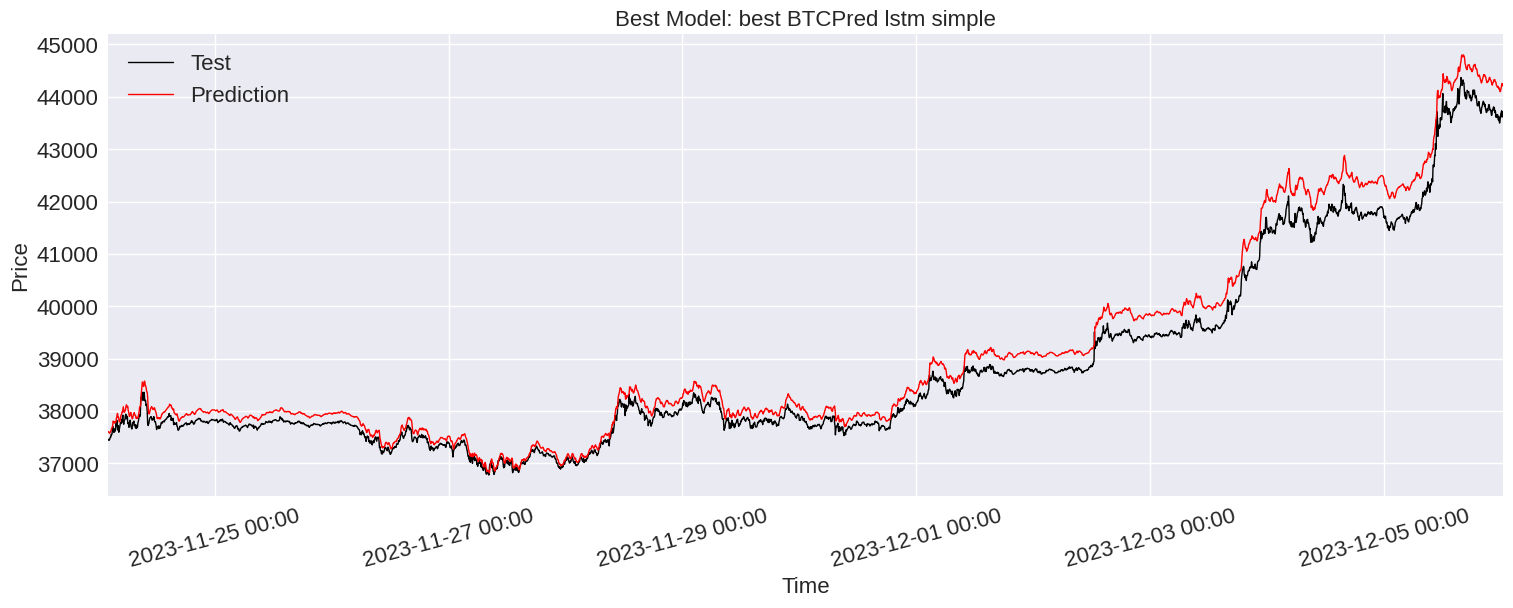

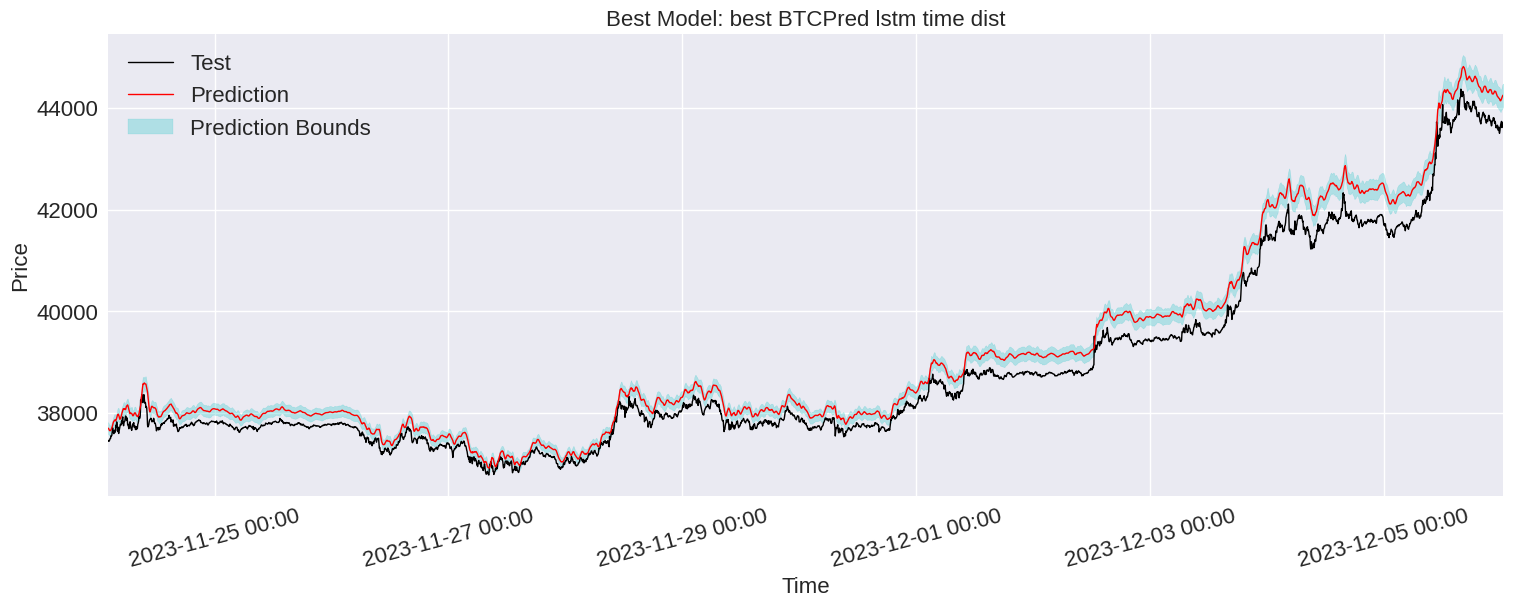

In [34]:
"""
Description:
- Plots the prediction results for a specific model, including the test set and predicted values.

Parameters:
- y_train (numpy.ndarray): True values for the training set.
- y_test (numpy.ndarray): True values for the test set.
- y_pred (numpy.ndarray): Predicted values for the test set.
- model_name (str): Name of the model for labeling the plot.
- whole_data (bool): If True, includes the entire dataset in the plot (default is False).

Returns:
- None
"""
for model_name in y_pred_best.keys():
    plot_prediction(y_train, y_test, y_pred_best[model_name], model_name = model_name.replace('_', ' '), whole_data = False)

# Residuals vs. Predicted Values Visualization

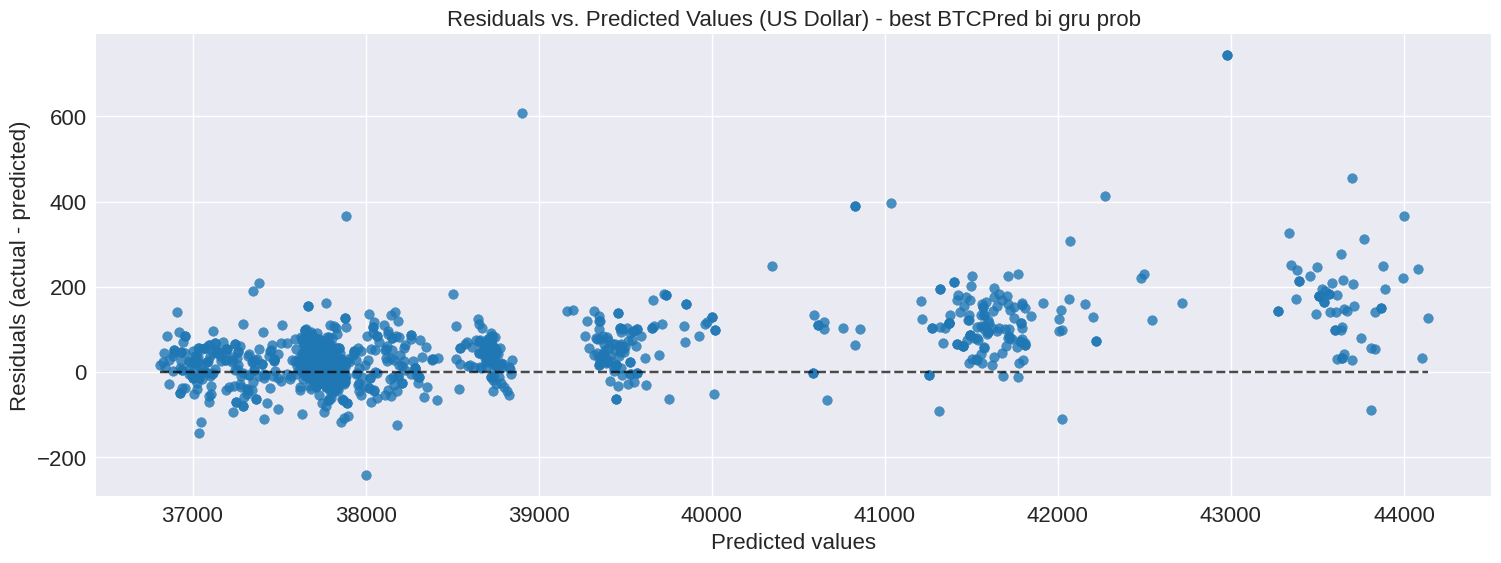

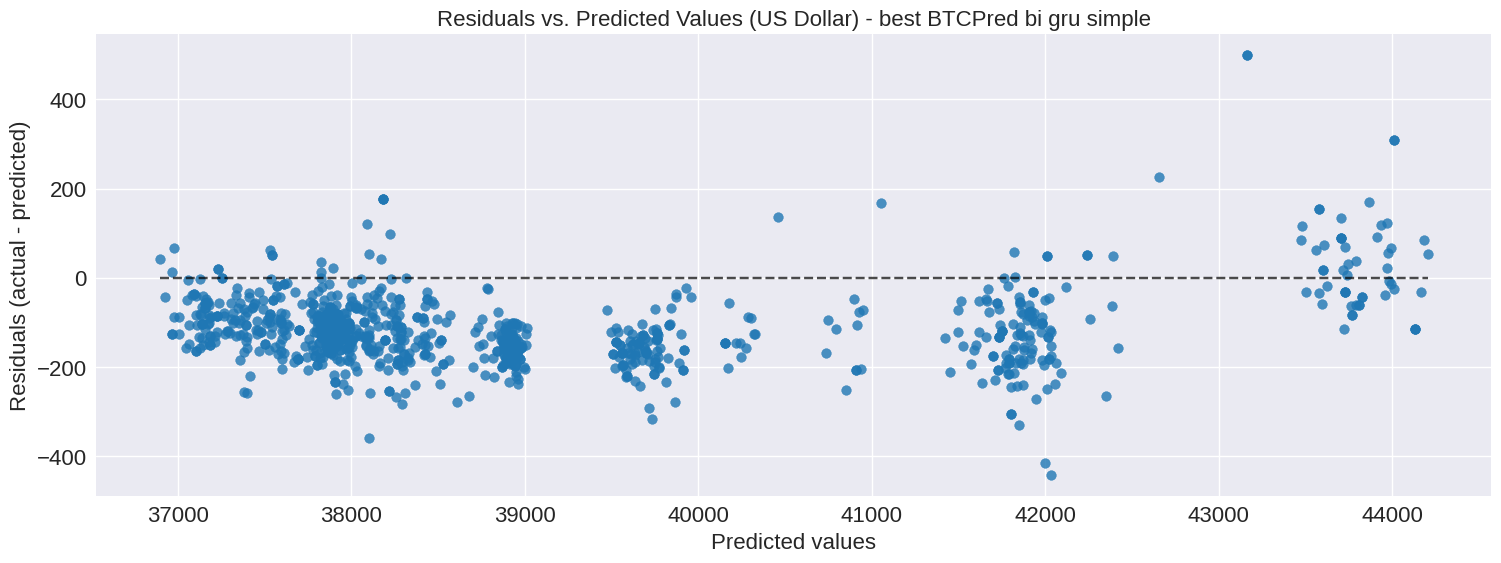

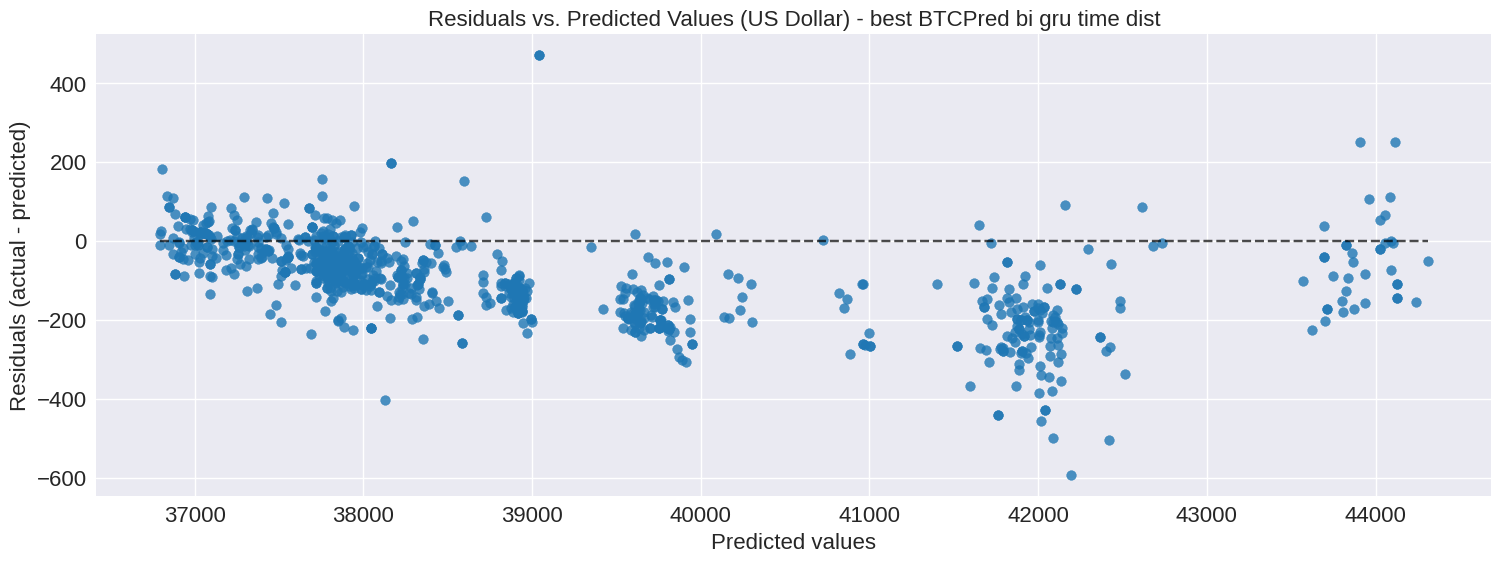

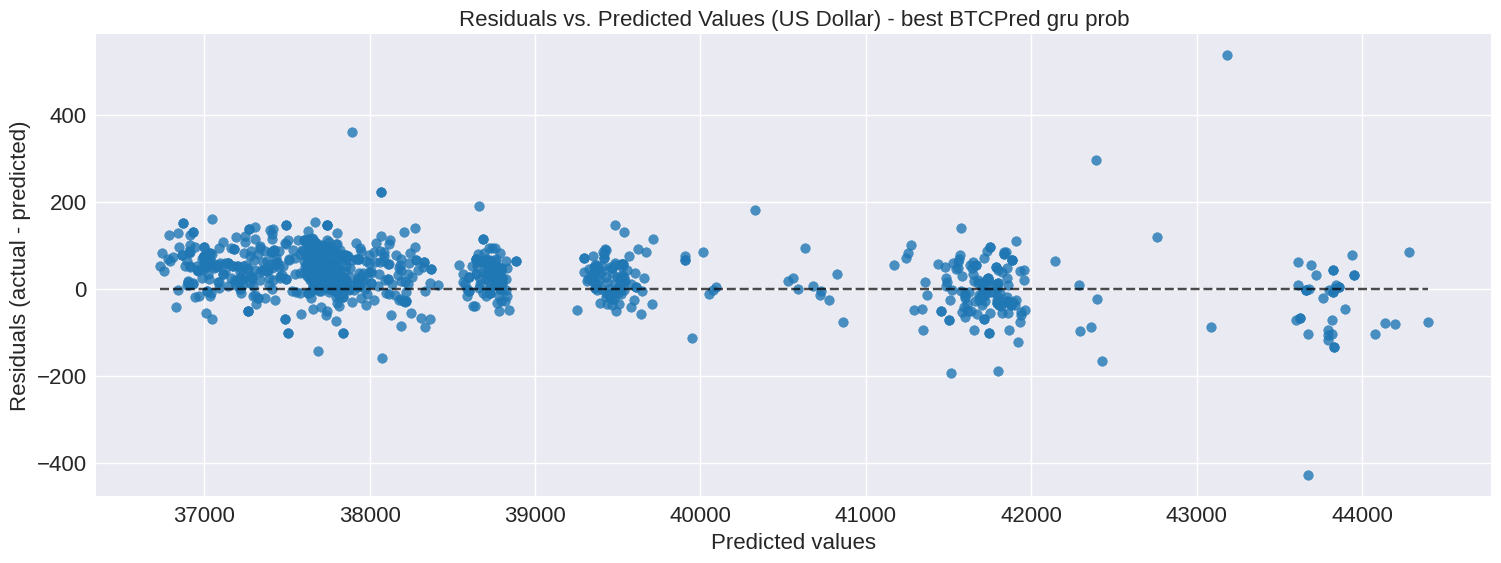

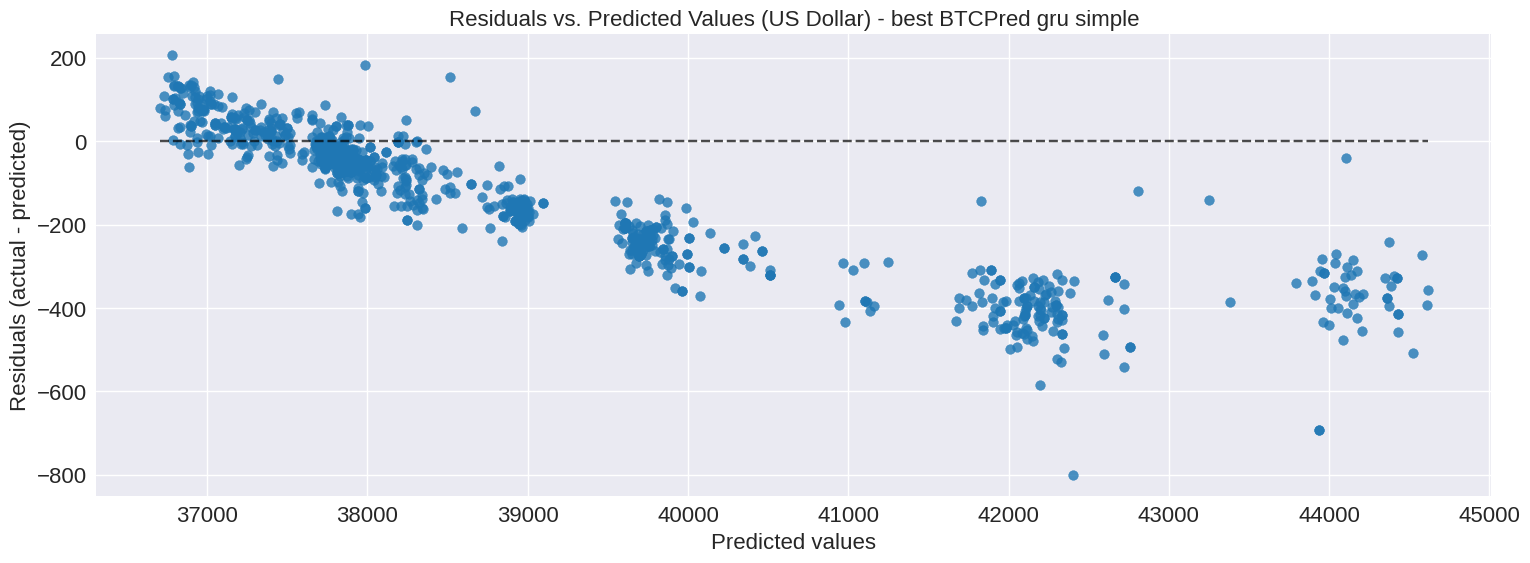

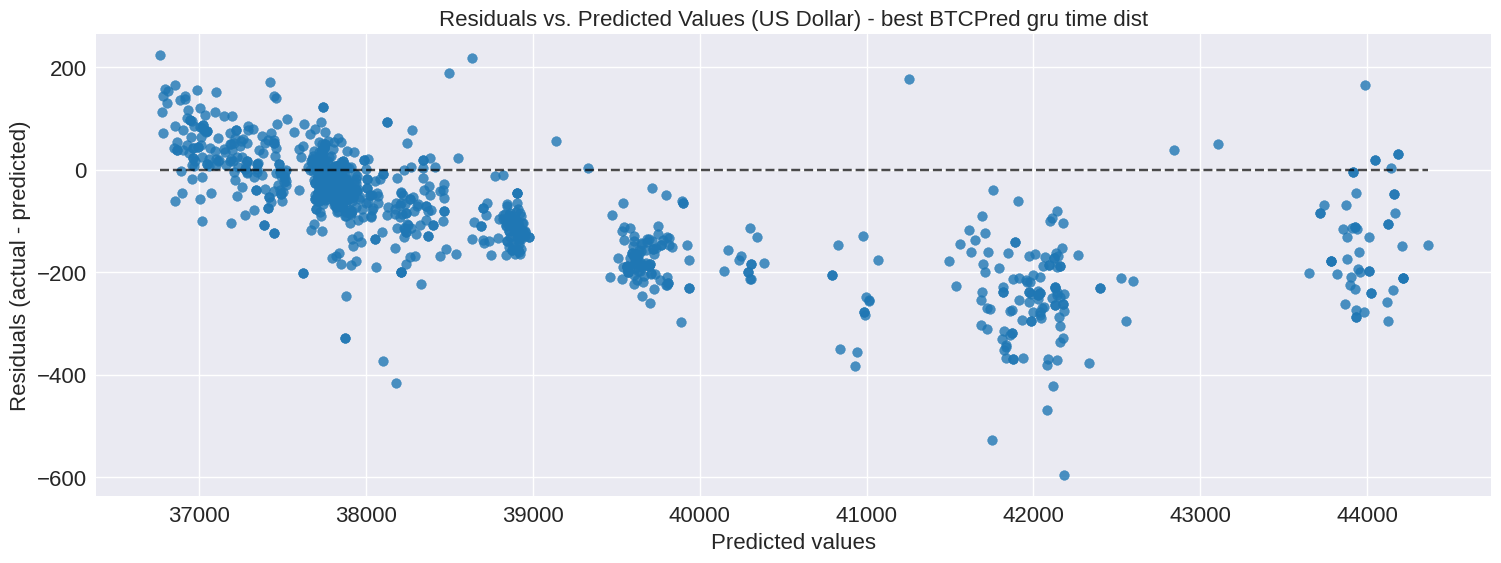

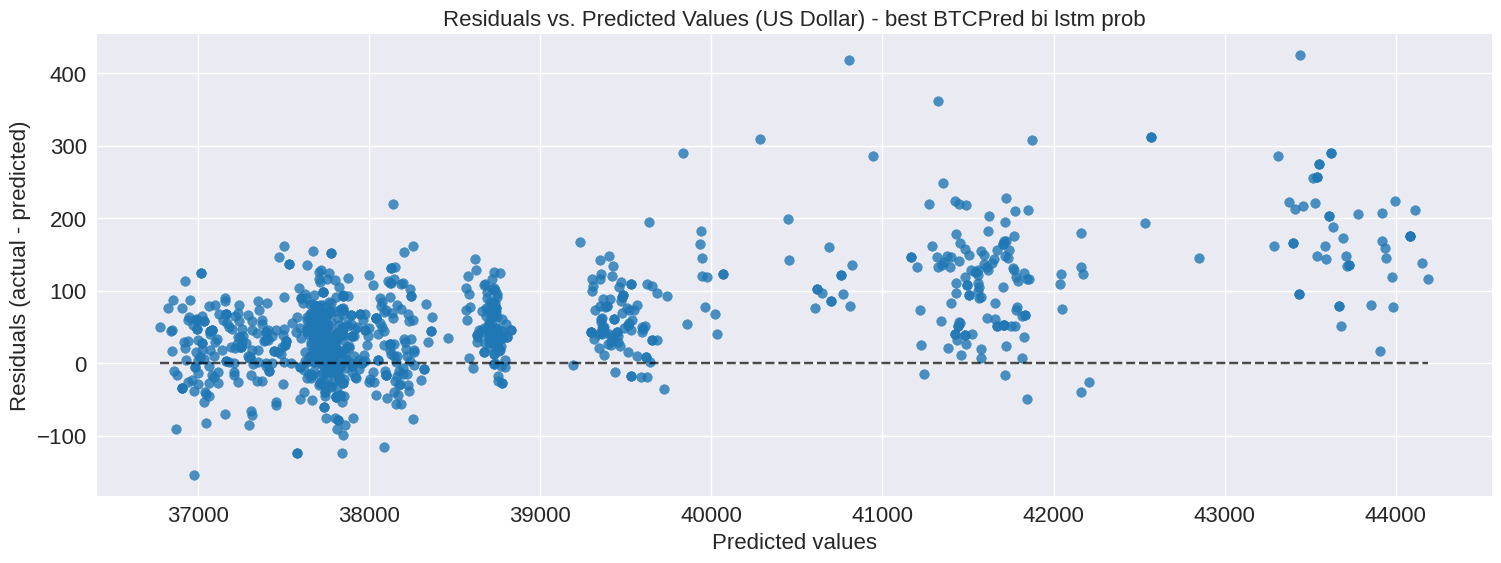

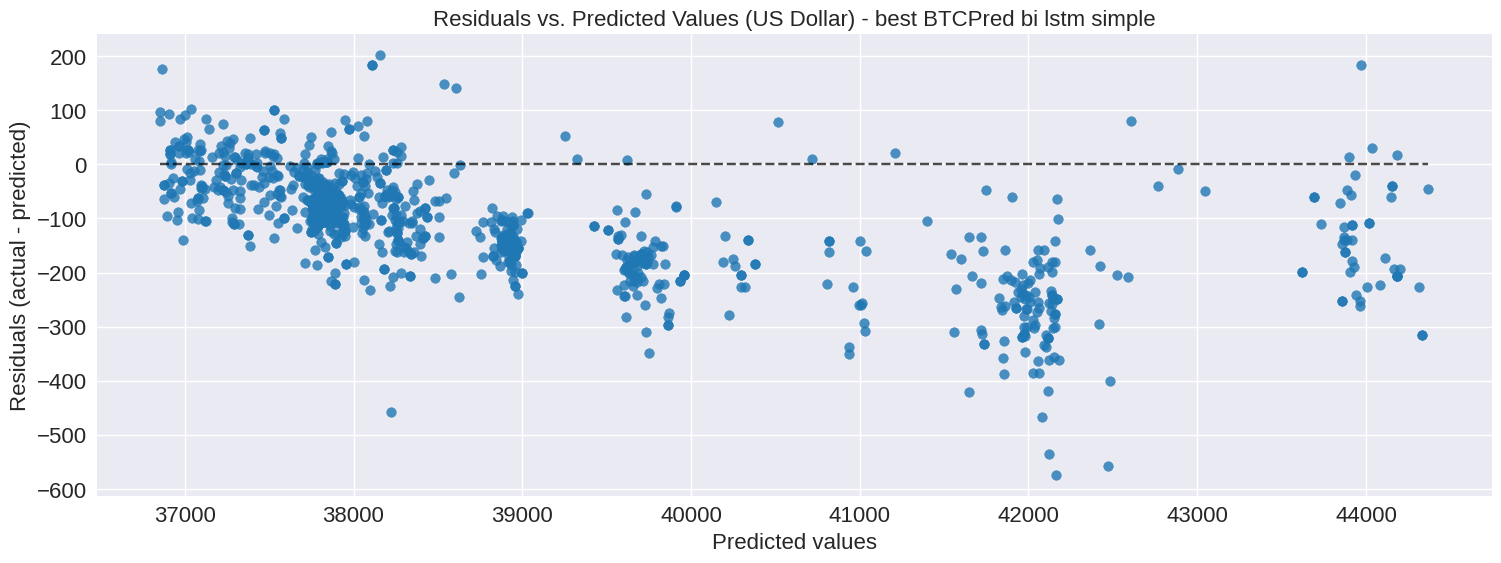

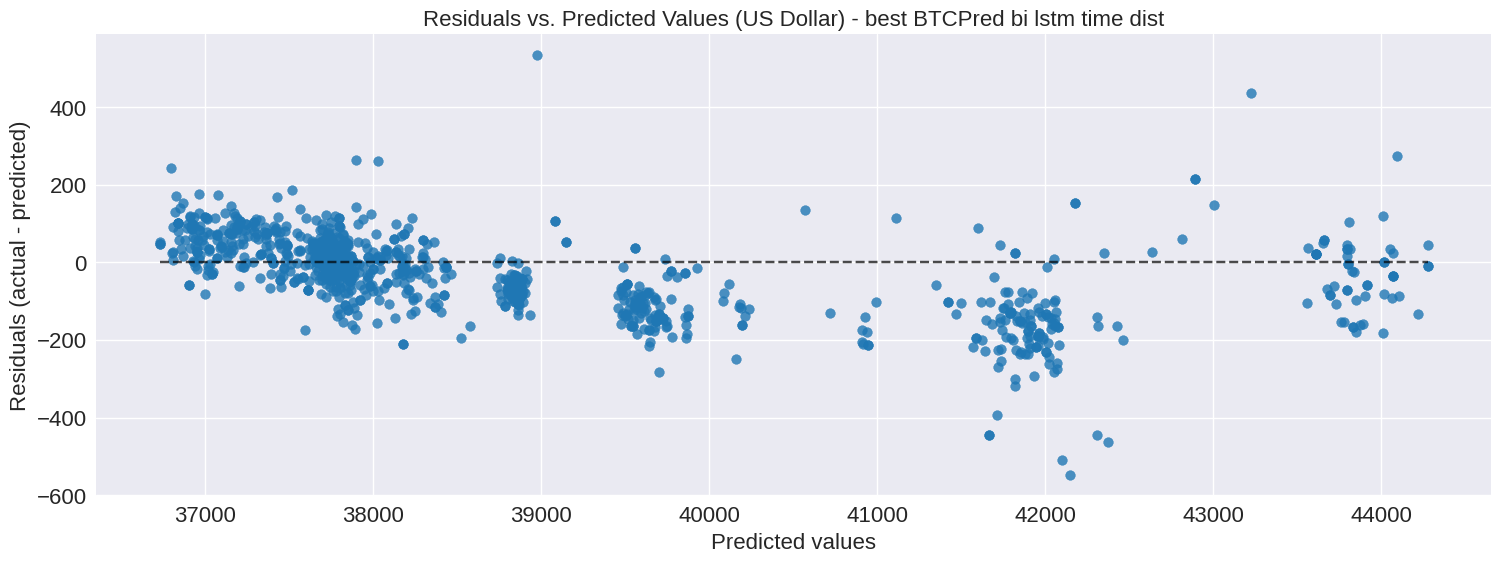

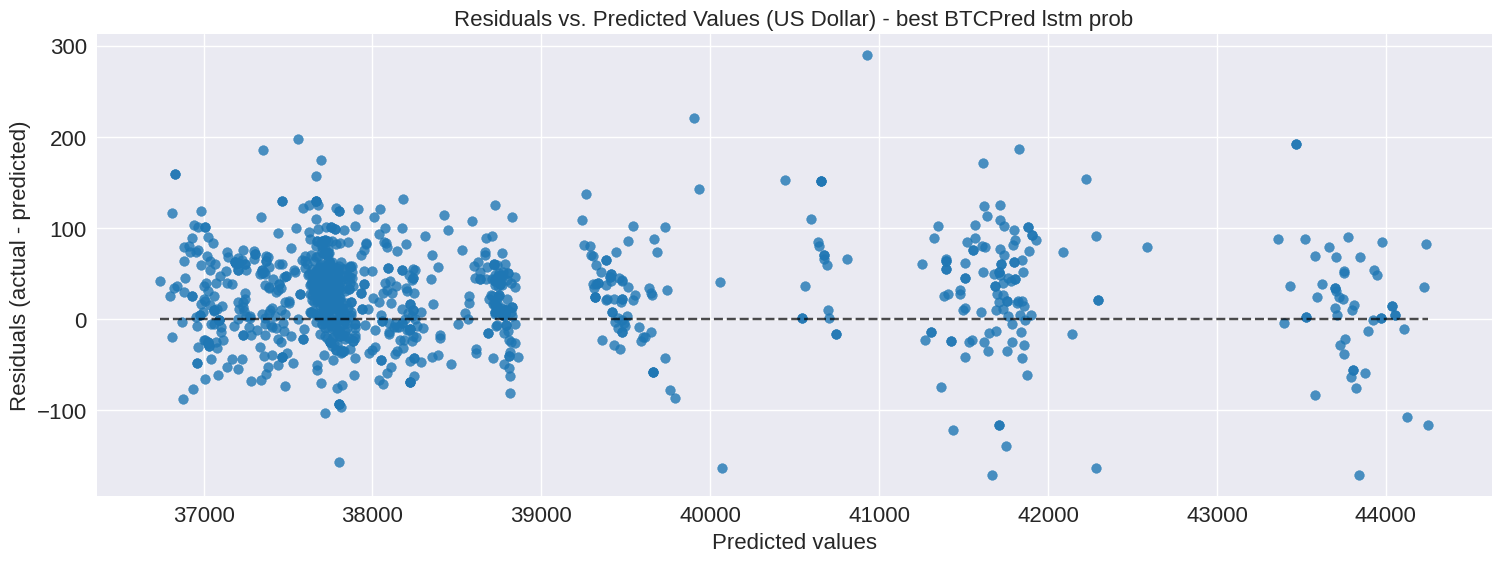

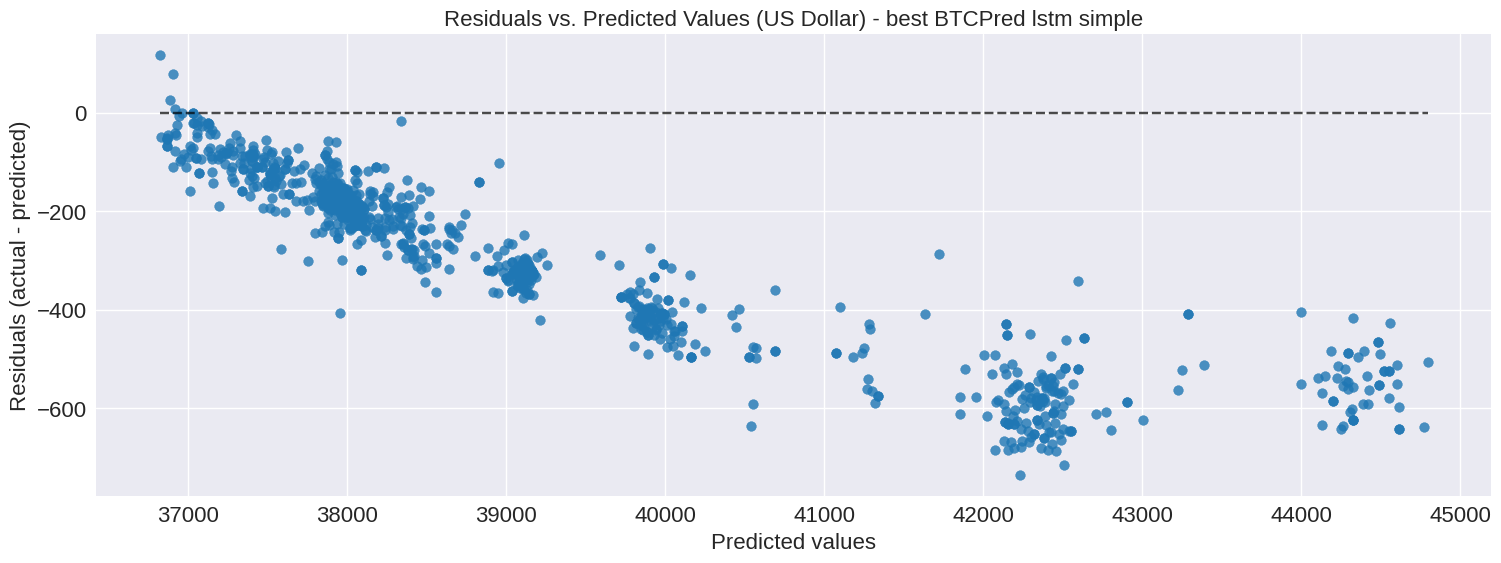

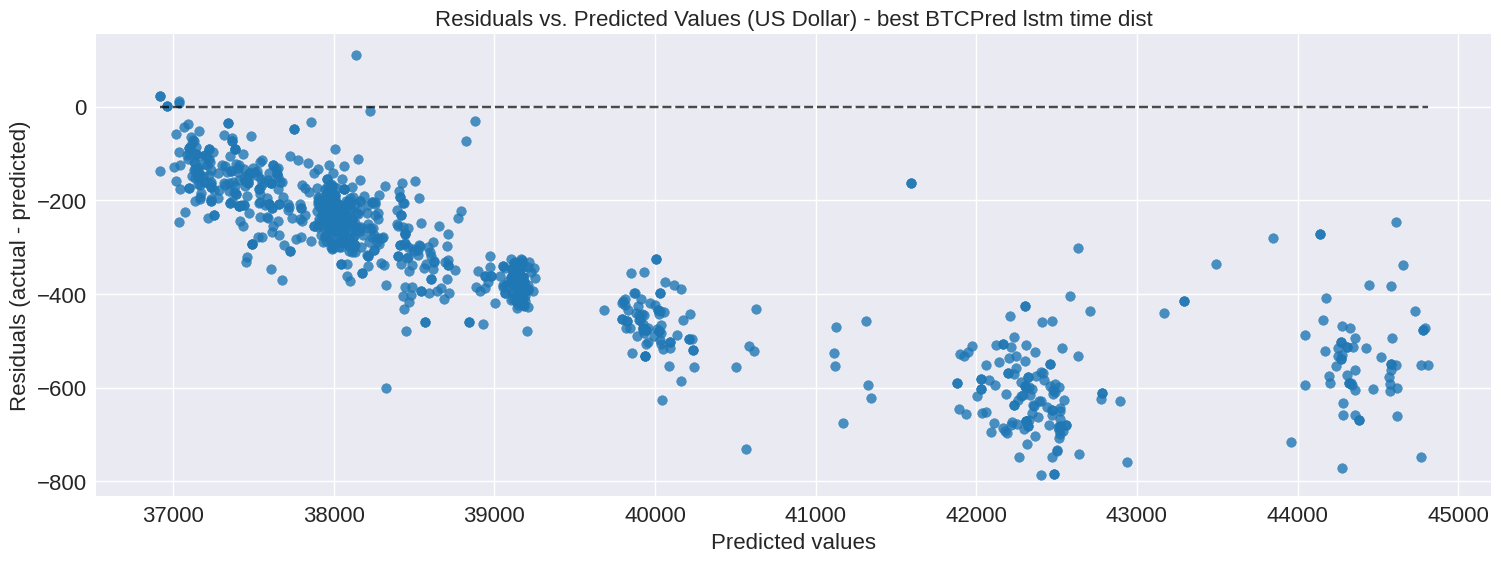

In [35]:
"""
Description:
- Visualize the relationship between residuals and predicted values for each model.

Parameters:
- y_test (numpy.ndarray): True labels for the test set.
- y_pred_best (dict): Predictions from the best models.
- close_minmax (numpy.ndarray): Min-max values for denormalization.

Visualization:
- Residuals vs. Predicted Values plot displays the difference between true and predicted values against the predicted values.
- Each plot corresponds to a specific model, showcasing the model's performance in predicting price residuals.

Note: Residuals are the differences between the true and predicted values, providing insights into the model's accuracy.
"""
for model_name in y_pred_best.keys():
    PredictionErrorDisplay.from_predictions(y_true = denormalize(y_test, close_minmax),
                                            y_pred = denormalize(y_pred_best[model_name].mean(axis = 1), close_minmax)[:, np.newaxis])
    plt.title(f'Residuals vs. Predicted Values (US Dollar) - {model_name.replace("_", " ")}')
    plt.show()

# Models evaluation results

In [36]:
df = pd.DataFrame.from_dict(models_test_result, orient = 'index')
df

r2_score  mean_absolute_percentage_error  \
best_BTCPred_bi_gru_prob        0.997893                        0.001492   
best_BTCPred_bi_gru_simple      0.993843                        0.003276   
best_BTCPred_bi_gru_time_dist   0.994724                        0.002661   
best_BTCPred_gru_prob           0.998722                        0.001283   
best_BTCPred_gru_simple         0.987486                        0.003661   
best_BTCPred_gru_time_dist      0.994310                        0.002575   
best_BTCPred_bi_lstm_prob       0.997728                        0.001619   
best_BTCPred_bi_lstm_simple     0.993333                        0.003010   
best_BTCPred_bi_lstm_time_dist  0.996798                        0.001941   
best_BTCPred_lstm_prob          0.998873                        0.001148   
best_BTCPred_lstm_simple        0.966541                        0.007122   
best_BTCPred_lstm_time_dist     0.958458                        0.008391   

                                explained_variance_score  \
best_BTCPred_bi_gru_prob                        0.998510   
best_BTCPred_bi_gru_simple                      0.997874   
best_BTCPred_bi_gru_time_dist                   0.997246   
best_BTCPred_gru_prob                           0.998993   
best_BTCPred_gru_simple                         0.992473   
best_BTCPred_gru_time_dist                      0.996111   
best_BTCPred_bi_lstm_prob                       0.998573   
best_BTCPred_bi_lstm_simple                     0.996907   
best_BTCPred_bi_lstm_time_dist                  0.997108   
best_BTCPred_lstm_prob                          0.999090   
best_BTCPred_lstm_simple                        0.990832   
best_BTCPred_lstm_time_dist                     0.991832   

                                mean_squared_log_error  mean_poisson_deviance  \
best_BTCPred_bi_gru_prob                      0.000004               0.169459   
best_BTCPred_bi_gru_simple                    0.000013               0.516448   
best_BTCPred_bi_gru_time_dist                 0.000011               0.431124   
best_BTCPred_gru_prob                         0.000003               0.107341   
best_BTCPred_gru_simple                       0.000024               0.993274   
best_BTCPred_gru_time_dist                    0.000011               0.458824   
best_BTCPred_bi_lstm_prob                     0.000005               0.184052   
best_BTCPred_bi_lstm_simple                   0.000014               0.542463   
best_BTCPred_bi_lstm_time_dist                0.000007               0.261336   
best_BTCPred_lstm_prob                        0.000002               0.093129   
best_BTCPred_lstm_simple                      0.000066               2.687702   
best_BTCPred_lstm_time_dist                   0.000084               3.366653   

                                  max_error  
best_BTCPred_bi_gru_prob         744.898438  
best_BTCPred_bi_gru_simple       738.707031  
best_BTCPred_bi_gru_time_dist    603.406250  
best_BTCPred_gru_prob            642.441406  
best_BTCPred_gru_simple          799.734375  
best_BTCPred_gru_time_dist       636.234375  
best_BTCPred_bi_lstm_prob        729.257812  
best_BTCPred_bi_lstm_simple      625.156250  
best_BTCPred_bi_lstm_time_dist   639.453125  
best_BTCPred_lstm_prob           654.632812  
best_BTCPred_lstm_simple         984.539062  
best_BTCPred_lstm_time_dist     1001.976562

# Download TRX-USD Price Data

In [37]:
"""
Description:
- Downloads historical price data for TRX-USD cryptocurrency using the Yahoo Finance API.
- Adjusts the timezone, date format, and ticker symbol for specific requirements.

Parameters:
- timezone (pytz.timezone): Timezone information for data timestamp adjustment.
- date_format (str): Format for representing dates.
- tickers (str): Ticker symbol for the cryptocurrency pair.

Returns:
- pandas.DataFrame: Historical price data for TRX-USD.
"""
data = download_price_data(timezone = iran_timezone, date_format = dateformat, tickers = 'TRX-USD')

[*********************100%%**********************]  1 of 1 completed
Downloaded from 2023-10-07 10:55 to 2023-12-06 00:35 with total 17157 samples


In [38]:
data

Open      High       Low     Close  AdjClose  Volume
Datetime                                                                  
2023-10-07 10:55  0.087334  0.087336  0.087332  0.087333  0.087333       0
2023-10-07 11:00  0.087333  0.087343  0.087333  0.087343  0.087343       0
2023-10-07 11:05  0.087348  0.087380  0.087348  0.087380  0.087380       0
2023-10-07 11:10  0.087409  0.087430  0.087409  0.087430  0.087430       0
2023-10-07 11:15  0.087432  0.087446  0.087432  0.087446  0.087446       0
...                    ...       ...       ...       ...       ...     ...
2023-12-06 00:15  0.102933  0.102941  0.102904  0.102941  0.102941   51392
2023-12-06 00:20  0.102949  0.103009  0.102949  0.103009  0.103009  143136
2023-12-06 00:25  0.103046  0.103046  0.102947  0.102947  0.102947   42880
2023-12-06 00:30  0.102951  0.102997  0.102951  0.102970  0.102970  119328
2023-12-06 00:35  0.102966  0.102966  0.102966  0.102966  0.102966       0

[17157 rows x 6 columns]

# Plot Downloaded TRX Price Data

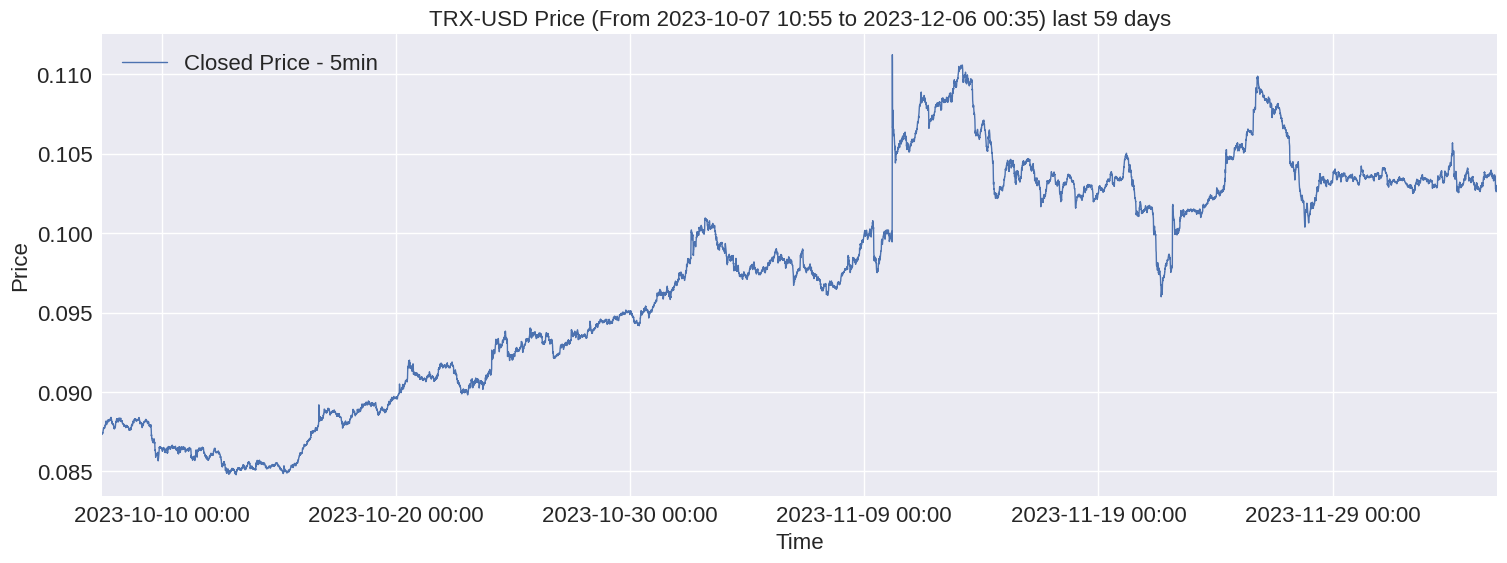

In [39]:
"""
Description:
- Plots the historical closed price of a cryptocurrency.
- The x-axis is formatted with a custom date formatter.

Parameters:
- data (pd.DataFrame): Historical price data with timestamps and closed prices.
- dateformat (str): Custom date format for timestamp display.
"""
dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index]

plt.gca().xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
plt.plot(dates, list(data['Close']), label = 'Closed Price - 5min', linewidth = 1)
plt.xlim([dates[0], dates[-1]])
plt.title('TRX-USD Price (From {} to {}) last {} days'
.format(data.index[0], data.index[-1], (datetime.strptime(data.index[-1], dateformat) - datetime.strptime(data.index[0], dateformat)).days))
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model Training Configuration

In [40]:
"""
Description:
- Configuration settings for training the time series prediction models.

Parameters:
- test_split_percentage (float): Percentage of data reserved for testing.
- validation_split_percentage (float): Percentage of training data used for validation.
- epochs (int): Number of training epochs.
- batch_size (int): Batch size for training.
- verbose (int): Verbosity level during training (0 for silent).
- analysis_duration (int): Duration of the sequence used for prediction.
- price_pairs (str): Symbol pairs for the cryptocurrency prices dataset.
"""
test_split_percentage = .8
validation_split_percentage = .2
epochs = 10
batch_size = 32
verbose = 0
analysis_duration = 6
price_pairs = 'TRXUSD'

# Price Preprocessing and Normalization Parameters

In [41]:
"""
Parameters for normalizing cryptocurrency closing prices:
- alpha (float): Scaling factor for the minimum value.
- beta (float): Scaling factor for the maximum value.
- close_price (numpy.ndarray): NumPy array containing closing prices.
- data_len (int): Total length of the price data.
- train_len (int): Length of the training data.
- test_len (int): Length of the testing data.
- close_minmax (numpy.ndarray): Min-max normalization range for closing prices.
"""
alpha, beta = .8, 1.2
close_price = pd.Series.to_numpy(data['Close'])
data_len = close_price.shape[0]
train_len = int((test_split_percentage * data_len) // analysis_duration * analysis_duration)
test_len = int(data_len - train_len)
close_minmax = np.array([alpha * close_price.min(), beta * close_price.max()], dtype = 'float32')

# Price Normalization and Save

In [42]:
"""
Description:
- Normalize the closing prices of cryptocurrency data and save the min-max normalization range.

Parameters:
- close_price (numpy.ndarray): Reshaped and normalized closing prices.
- data_len (int): Total length of the price data.
- close_minmax (numpy.ndarray): Min-max normalization range for closing prices.
- price_pairs (str): Symbol pairs for the cryptocurrency prices dataset.
"""
close_price = close_price.reshape((data_len, 1)).astype('float32')
close_price = normalize(close_price, close_minmax)
np.save(f'close_minmax_{price_pairs.lower()}.npy', close_minmax)

# Data Splitting for Training and Validation

In [43]:
"""
Description:
- Split the time series data into training, testing, and validation sets for model training.

Parameters:
- X_train, y_train, X_test, y_test (numpy.ndarray): Training and testing data split.
- X_val, y_val (numpy.ndarray): Validation data split from the training set.
- close_price (numpy.ndarray): Reshaped and normalized closing prices.
- train_len (int): Length of the training data.
- test_len (int): Length of the testing data.
- validation_split_percentage (float): Percentage of training data used for validation.
- analyzing_duration (int): Duration of the sequence used for prediction.
"""
X_train, y_train, X_test, y_test = split_data(close_price = close_price, training_len = train_len, testing_len = test_len, analyzing_duration = analysis_duration)
X_val, y_val = X_train[int(train_len - (validation_split_percentage * train_len)):], y_train[int(train_len - (validation_split_percentage * train_len)):]
X_train, y_train = X_train[:int(train_len - (validation_split_percentage * train_len))], y_train[:int(train_len - (validation_split_percentage * train_len))]

# Transfer Learning with Probabilistic GRU Model (train on TRX price data)

In [44]:
"""
Description:
- Performs transfer learning by loading a pre-trained Probabilistic GRU model.
- Transfer learning is a machine learning technique where knowledge gained from one model (source model) is applied to another related model (target model).
- In this code, transfer learning is implemented for time series forecasting using a pre-trained Probabilistic GRU model.
- The source model, 'best_BTCPred_gru_prob,' is trained on Bitcoin price data.
- The target model, 'best_TRXPred_gru_prob,' is trained on Tron price data using the weights transferred from the source model.
- This approach leverages the learned patterns and features from the Bitcoin data to enhance the training of the Tron model.
- The transfer_model() function loads the pre-trained model, freezes the layers up to the output layer, and compiles it for training.
- The model is then trained on Tron data, and the performance is evaluated and recorded in transfer_model_test_result.
- Various metrics such as R2 score, mean absolute percentage error, explained variance score, etc., are used to assess the model's performance.


Parameters:
- K.clear_session(): Clears the Keras session to release resources.
- m_name_ (str): Model name for identification.
- transfer_model_test_result (dict): Dictionary to store evaluation results.
- model (tf.keras.Model): Transfer learning model loaded from a pre-trained model.
- out_path_best (str): Path to store the best model during training.
- X_train, y_train, X_test, y_test (numpy.ndarray): Training and test data.
- epochs, batch_size, verbose (int): Training parameters.
- close_minmax (numpy.ndarray): Min-max values for denormalization.

Returns:
- None: The transfer learning model is trained, evaluated, and results are recorded in transfer_model_test_result.
"""
K.clear_session()
m_name_ = 'best_TRXPred_gru_prob'
transfer_model_test_result = {}
transfer_model_test_result.update({f'{m_name_}': {}})
model = transfer_model()
model.summary(line_length = 140)

tbcall = TrainingCallback(model_dir = out_path_best,
                          valid_data = (X_val, y_val),
                          model = model, model_name = m_name_)

model_history = model.fit(X_train, y_train,
                          epochs = epochs, batch_size = batch_size, callbacks = tbcall, verbose = verbose)

model.save(f'{out_path}/{m_name_.replace("best", "fulltrained")}.keras')
best_model = load_model(f'{out_path_best}/{m_name_}.keras', safe_mode = False)

test_p = model.predict(X_test)
test_p_best = best_model.predict(X_test)
y_pred_best.update({f'{m_name_}': test_p_best})

transfer_model_test_result[f'{m_name_}'].update({'r2_score': float(r2_score(denormalize(y_test, close_minmax),
                                                                            denormalize(test_p_best.mean(axis = 1), close_minmax)))})
transfer_model_test_result[f'{m_name_}'].update({'mean_absolute_percentage_error': float(mape(denormalize(y_test, close_minmax),
                                                                                              denormalize(test_p_best.mean(axis = 1), close_minmax)))})
transfer_model_test_result[f'{m_name_}'].update({'explained_variance_score': float(evs(denormalize(y_test, close_minmax),
                                                                                       denormalize(test_p_best.mean(axis = 1), close_minmax)))})
transfer_model_test_result[f'{m_name_}'].update({'mean_squared_log_error': float(msle(denormalize(y_test, close_minmax),
                                                                                      denormalize(test_p_best.mean(axis = 1), close_minmax)))})
transfer_model_test_result[f'{m_name_}'].update({'mean_poisson_deviance': float(mpd(denormalize(y_test, close_minmax),
                                                                                    denormalize(test_p_best.mean(axis = 1), close_minmax)))})
transfer_model_test_result[f'{m_name_}'].update({'max_error': float(max_error(denormalize(y_test, close_minmax),
                                                                              denormalize(test_p_best.mean(axis = 1), close_minmax)))})

Model: "best_TRXPred_gru_prob"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                                  Output Shape                                            Param #              
 close_price (InputLayer)                                      [(None, 6, 1)]                                          0                    
                                                                                                                                            
 gru (GRU)                                                     (None, 256)                                             198912               
                                                                                                                                            
 batch_normalization (BatchNormalization)                      (None, 256)                                             1024

Training started. Checking the best model based on the highest R2-score is On
86/86 [==============================] - 1s 3ms/step


Epoch: 01/10 | 0:00:05 | Price R2 score: 0.9204 | loss: 5.3187 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 3ms/step
Epoch: 02/10 | 0:00:01 | Price R2 score: -0.4533 | loss: 1.4734 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 03/10 | 0:00:01 | Price R2 score: 0.5966 | loss: 2.1119 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 04/10 | 0:00:01 | Price R2 score: -3.7223 | loss: 2.8321 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 05/10 | 0:00:02 | Price R2 score: 0.9445 | loss: 1.8503 | Model Weights Changed And Best Model Saved
86/86 [==============================] - 0s 4ms/step
Epoch: 06/10 | 0:00:02 | Price R2 score: -1.1864 | loss: 1.7241 | Model Weights Not Changed
86/86 [==============================] - 0s 3ms/step
Epoch: 07/10 | 0:00:01 | Price R2 score: 0.5062 | loss: 1.7734 | Model Weights Not Changed
86/86 [=

# Prediction visualization

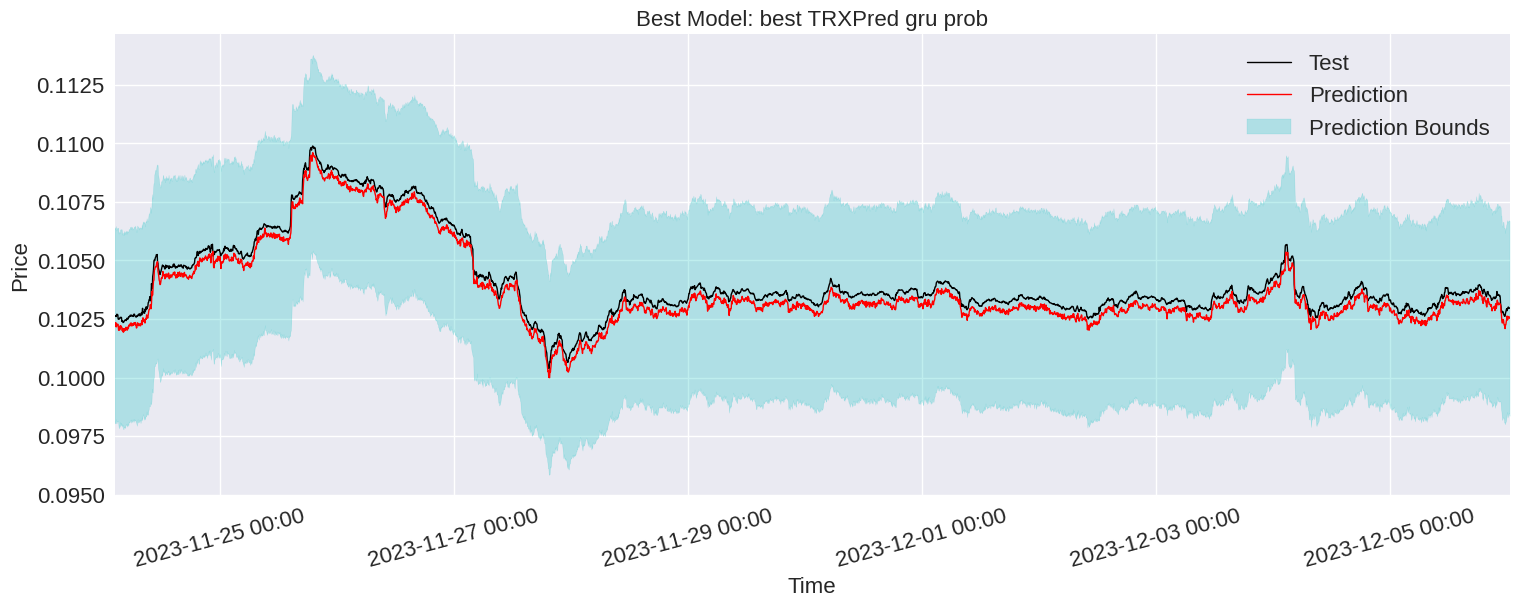

In [45]:
plot_prediction(y_train, y_test, y_pred_best[m_name_], model_name = m_name_.replace('_', ' '), whole_data = False)

# Residuals vs. Predicted Values Visualization

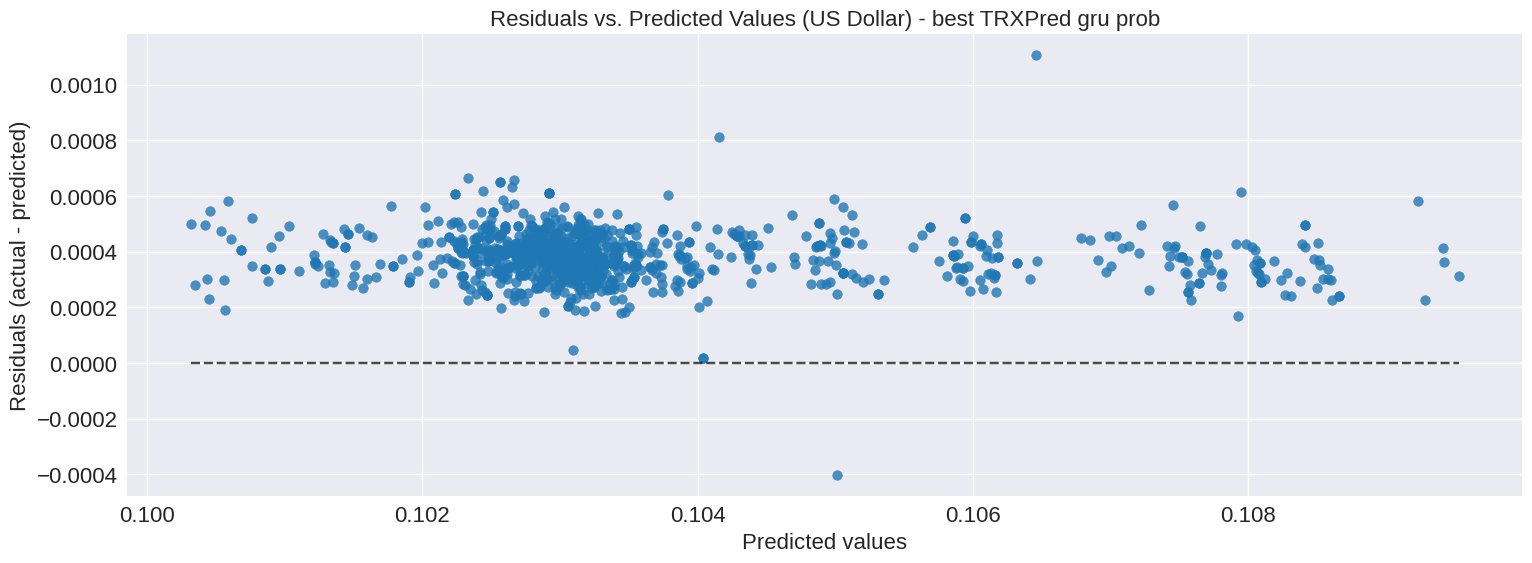

In [46]:
PredictionErrorDisplay.from_predictions(y_true = denormalize(y_test, close_minmax),
                                        y_pred = denormalize(y_pred_best[m_name_].mean(axis = 1), close_minmax)[:, np.newaxis])
plt.title(f'Residuals vs. Predicted Values (US Dollar) - {m_name_.replace("_", " ")}')
plt.show()

# Models evaluation results

In [47]:
df = pd.DataFrame.from_dict(transfer_model_test_result, orient = 'index')
df

r2_score  mean_absolute_percentage_error  \
best_TRXPred_gru_prob   0.94974                        0.003656   

                       explained_variance_score  mean_squared_log_error  \
best_TRXPred_gru_prob                  0.997378            1.248411e-07   

                       mean_poisson_deviance  max_error  
best_TRXPred_gru_prob               0.000001   0.001108